<h1 style="text-align:center">Personalized cancer diagnosis</h1>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
# Running in google colab
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/AAIC/Personalized\ Cancer\ Diagnosis

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/AAIC/Personalized Cancer Diagnosis


In [0]:
data = pd.read_csv('training_variants.txt')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

In [0]:
data_text = pd.read_csv("training_text.txt",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...

<h3>Preprocessing of text</h3>

In [0]:
# loading stop words from nltk library
import nltk
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 198.40328 seconds


In [0]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

ID    Gene  ... Class                                               TEXT
0   0  FAM58A  ...     1  cyclin dependent kinases cdks regulate variety...
1   1     CBL  ...     2  abstract background non small cell lung cancer...
2   2     CBL  ...     2  abstract background non small cell lung cancer...
3   3     CBL  ...     3  recent evidence demonstrated acquired uniparen...
4   4     CBL  ...     4  oncogenic mutations monomeric casitas b lineag...

[5 rows x 5 columns]

In [0]:
result[result.isnull().any(axis=1)]

ID    Gene             Variation  Class TEXT
1109  1109   FANCA                S1088F      1  NaN
1277  1277  ARID5B  Truncating Mutations      1  NaN
1407  1407   FGFR3                 K508M      6  NaN
1639  1639    FLT1         Amplification      6  NaN
2755  2755    BRAF                 G596C      7  NaN

In [0]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [0]:
result[result['ID']==1109]

ID   Gene Variation  Class          TEXT
1109  1109  FANCA    S1088F      1  FANCA S1088F

<h3>Test, Train and Cross Validation Split</h3>

<h4>Splitting data into train, test and cross validation (64:20:16)</h4>

In [0]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

<p> We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set  </p>

In [0]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h3>Util Functions</h3>

In [0]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [0]:
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict

def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

In [0]:
dd = {'x': [1, 2, 3]}

In [0]:
dumm_dd = dd.copy()
dumm_dd['y'] = [2, 3, 4]
print(dumm_dd)
print(dd)

{'x': [1, 2, 3], 'y': [2, 3, 4]}
{'x': [1, 2, 3]}


In [0]:
def generic_model_run(model, params, hyper_param_dict, x_train, y_train, x_cv, y_cv, x_test=None, y_test=None):
    """
      model: Model that you want to train (ex: LinearRegression, SGDClassifier just model name, not a function).
      params: dictionary of fixed parameters (ex: {'penalty': 'l2', 'loss': 'log'})
      hyper_param_dict: dictionary with only one item consisting of key as the
                  parameter you want to tune and value as array of values to pass (ex: {'alpha': [0.01, 0.1, 1, 10]})
      x_train, y_train, x_cv, y_cv: These are the data on which our model has to be trained on and hyper-parameter tuned on.
      x_test, y_test: Test data on which our best model after training gives score.
      Returns the best model that has low log_loss.
    """
    cv_log_error_array=[]
    hp_vals = list(hyper_param_dict.values())[0]
    hp_name = list(hyper_param_dict.keys())[0]
    for i in hp_vals:
        all_params = params.copy()
        all_params[hp_name] = i
        clf = model(**all_params)
        clf.fit(x_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(x_train, y_train)
        predict_y = sig_clf.predict_proba(x_cv)
        cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
        print(f'For values of {hp_name} = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

    fig, ax = plt.subplots()
    ax.plot(hp_vals, cv_log_error_array, c='g')
    for i, txt in enumerate(np.round(cv_log_error_array,3)):
        ax.annotate((hp_vals[i], np.round(txt,3)), (hp_vals[i], cv_log_error_array[i]))
    plt.grid()
    plt.title(f"Cross Validation Error for each {hp_name}")
    plt.xlabel(hp_name)
    plt.ylabel("Error measure")
    plt.show()


    best_alpha = np.argmin(cv_log_error_array)
    params[hp_name] = hp_vals[best_alpha]
    clf = model(**params)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)

    predict_y = sig_clf.predict_proba(x_train)
    print(f'For values of best {hp_name} = ', hp_vals[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(x_cv)
    print(f'For values of best {hp_name} = ', hp_vals[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    if x_test is not None and y_test is not None:
      predict_y = sig_clf.predict_proba(x_test)
      print(f'For values of best {hp_name} = ', hp_vals[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

    return sig_clf

In [0]:
def generic_best_model_result(model, x_test, y_test, need_plot = True):
    y_probs = model.predict_proba(x_test)
    print("Log Loss :",log_loss(y_test, y_probs))
    y_preds = model.predict(x_test)
    print("Number of missclassified point :", np.count_nonzero((y_preds - y_test))/y_test.shape[0])
    if need_plot:
      plot_confusion_matrix(y_test, y_preds)

In [0]:
def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)
    
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<h3>Prediction of a Random Classifier</h3>

Log loss on Cross Validation Data using Random Model 2.4709855617780154
Log loss on Test Data using Random Model 2.513319117837328
-------------------- Confusion matrix --------------------


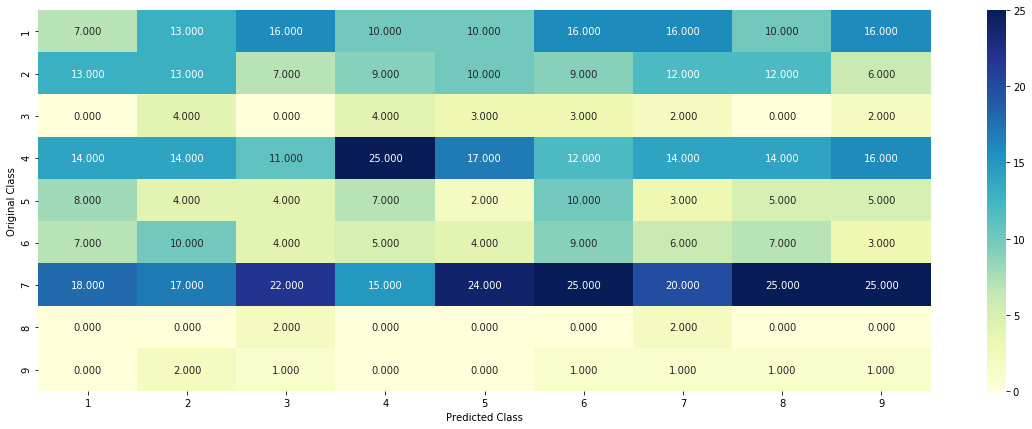

-------------------- Precision matrix (Columm Sum=1) --------------------


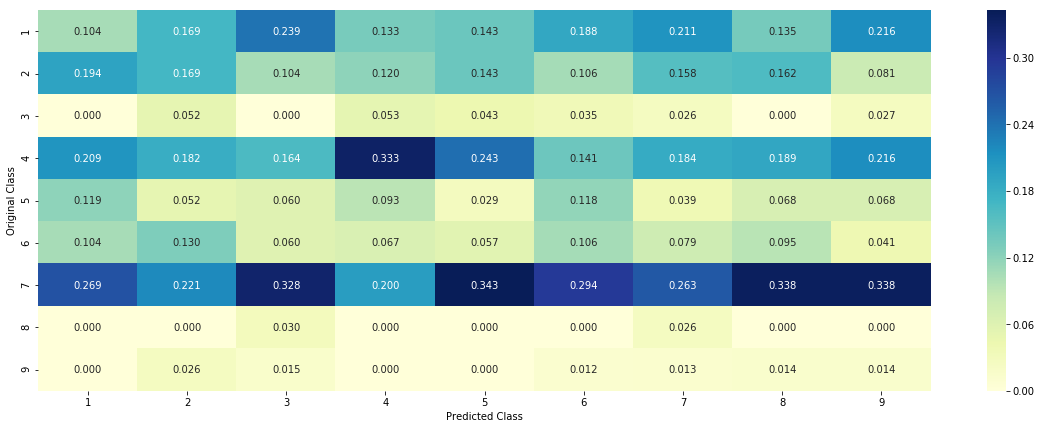

-------------------- Recall matrix (Row sum=1) --------------------


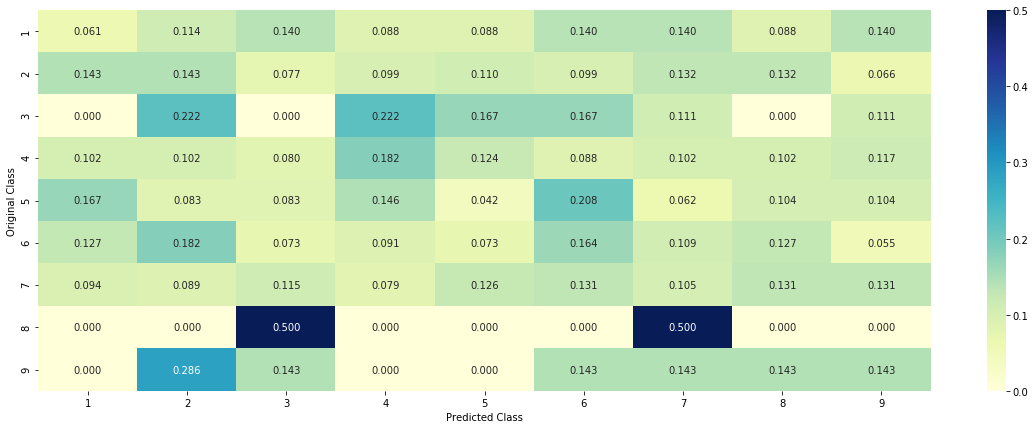

In [0]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

<h3>Prediction using a Dummy Classifier.</h3>

In [0]:
from sklearn.dummy import DummyClassifier

(532, 9)
(665, 9)
Log loss on Test Data using Dummy Classifier 1.8305865898503335
Log loss on CV Data using Dummy Classifier 1.830234679574716
-------------------- Confusion matrix --------------------


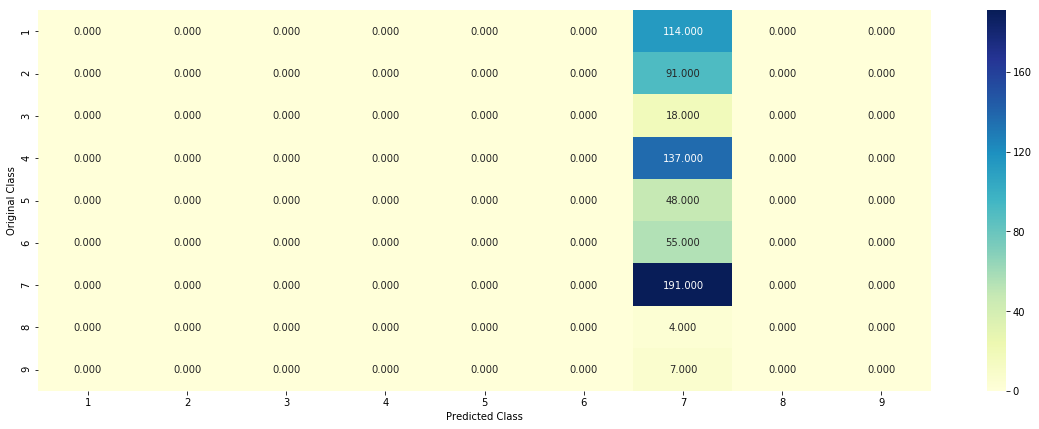

-------------------- Precision matrix (Columm Sum=1) --------------------


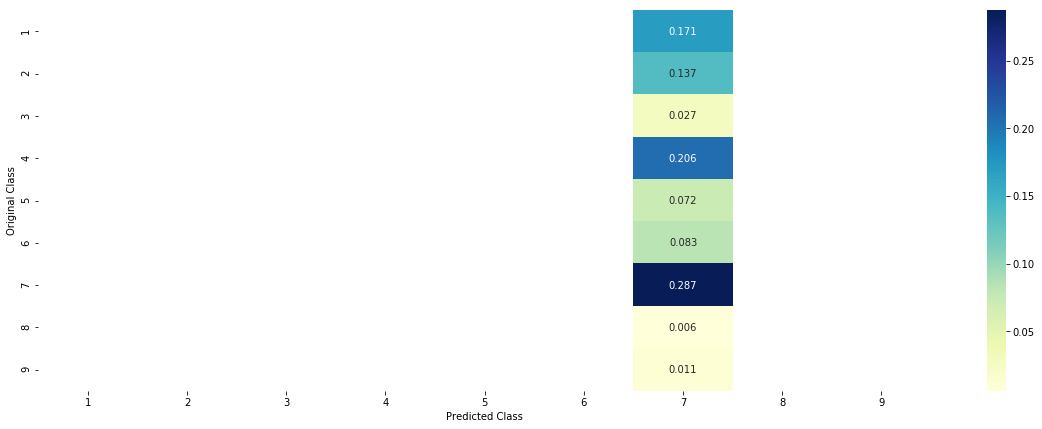

-------------------- Recall matrix (Row sum=1) --------------------


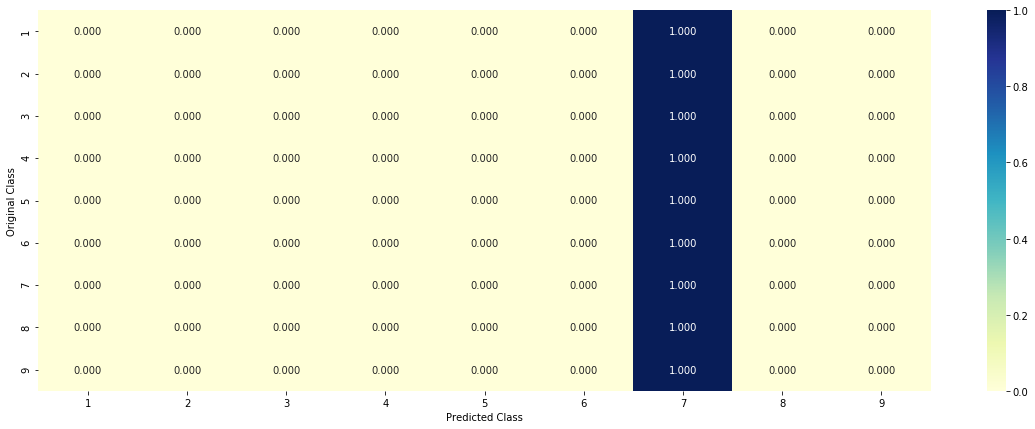

In [0]:
dummy_model = DummyClassifier(strategy='prior')
dummy_model.fit(train_df, y_train)
cv_predicted = dummy_model.predict_proba(cv_df)
test_predicted = dummy_model.predict_proba(test_df)
print(cv_predicted.shape)
print(test_predicted.shape)

print("Log loss on Test Data using Dummy Classifier",log_loss(y_test,test_predicted, eps=1e-15))
print("Log loss on CV Data using Dummy Classifier",log_loss(y_cv,cv_predicted, eps=1e-15))

predicted_y = np.argmax(test_predicted, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

**Minimum log-loss from both random and prior classifers is 1.83. which is our limit to the worst model. As our classes are unbalanced we got less log-loss value for prior classifier.**

<h2>Encoding the features of our data</h2>

**Encoding `Gene` Feature**

In [0]:
alpha = 1
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [0]:
print(train_gene_feature_responseCoding.shape)
print(test_gene_feature_responseCoding.shape)
print(cv_gene_feature_responseCoding.shape)

print(train_gene_feature_onehotCoding.shape)
print(test_gene_feature_onehotCoding.shape)
print(cv_gene_feature_onehotCoding.shape)

(2124, 9)
(665, 9)
(532, 9)
(2124, 234)
(665, 234)
(532, 234)


In [0]:
print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

(2124,)
(532,)
(665,)


**Testing how much good `Gene` feature can classify**

For values of alpha =  1e-05 The log loss is: 1.1972509391344373
For values of alpha =  0.0001 The log loss is: 1.1502936962681922
For values of alpha =  0.001 The log loss is: 1.1912044038188117
For values of alpha =  0.01 The log loss is: 1.324826076300454
For values of alpha =  0.1 The log loss is: 1.439695582806778
For values of alpha =  1 The log loss is: 1.4794163897431338


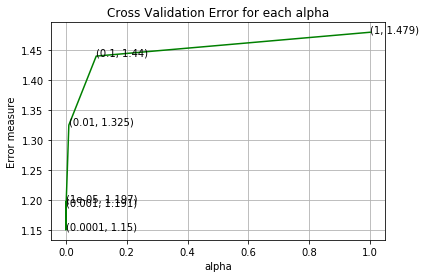

For values of best alpha =  0.0001 The train log loss is: 1.0139663825419314
For values of best alpha =  0.0001 The cross validation log loss is: 1.1482098126817135
For values of best alpha =  0.0001 The test log loss is: 1.1889494960801728


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffle=True, tol=0.001,
                                        

In [0]:
params = {'penalty': 'l2', 'loss': 'log'}
generic_model_run(SGDClassifier, params, {'alpha': [10 ** x for x in range(-5, 1)]},\
                 train_gene_feature_onehotCoding, y_train,\
                 cv_gene_feature_onehotCoding, y_cv,\
                 test_gene_feature_onehotCoding, y_test)

**Classification on Gene feature did pretty good for one feature. Far from random or prior model.**

**Encoding `Variation` Feature**

In [0]:
alpha = 1
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [0]:
print(train_variation_feature_responseCoding.shape)
print(test_variation_feature_responseCoding.shape)
print(cv_variation_feature_responseCoding.shape)

print(train_variation_feature_onehotCoding.shape)
print(test_variation_feature_onehotCoding.shape)
print(cv_variation_feature_onehotCoding.shape)

(2124, 9)
(665, 9)
(532, 9)
(2124, 1958)
(665, 1958)
(532, 1958)


**Testing how much good `Variation` feature can classify**

For values of alpha =  1e-05 The log loss is: 1.700061244425901
For values of alpha =  0.0001 The log loss is: 1.6920247398090085
For values of alpha =  0.001 The log loss is: 1.6945744214615004
For values of alpha =  0.01 The log loss is: 1.7088997815167413
For values of alpha =  0.1 The log loss is: 1.7188996804081524
For values of alpha =  1 The log loss is: 1.7203494473666552


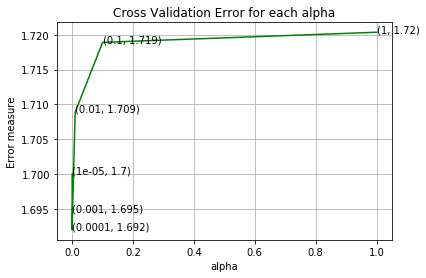

For values of best alpha =  0.0001 The train log loss is: 0.7556121355616767
For values of best alpha =  0.0001 The cross validation log loss is: 1.692816723592187
For values of best alpha =  0.0001 The test log loss is: 1.7238998080240018


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffle=True, tol=0.001,
                                        

In [0]:
params = {'penalty': 'l2', 'loss': 'log'}
generic_model_run(SGDClassifier, params, {'alpha': [10 ** x for x in range(-5, 1)]},\
                 train_variation_feature_onehotCoding, y_train,\
                 cv_variation_feature_onehotCoding, y_cv,\
                 test_variation_feature_onehotCoding, y_test)

**Variation feature is not as good as Gene feature and loss is close to prior dummy classifier.**

**Encoding `Text` feature and combining all features.**

In [0]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [0]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0 
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [0]:
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

train_text_features= text_vectorizer.get_feature_names()

train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 54091


In [0]:
dict_list = []
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    dict_list.append(extract_dictionary_paddle(cls_text))

total_dict = extract_dictionary_paddle(train_df)
    
confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [0]:
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [0]:
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [0]:
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [0]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [0]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56283)
(number of data points * number of features) in test data =  (665, 56283)
(number of data points * number of features) in cross validation data = (532, 56283)


In [0]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


In [0]:
text_tfidf_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_tfidf = text_tfidf_vectorizer.fit_transform(train_df['TEXT'])

train_text_features= text_tfidf_vectorizer.get_feature_names()

train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 54091


In [0]:
train_text_feature_tfidf = normalize(train_text_feature_tfidf, axis=0)

test_text_feature_tfidf = text_tfidf_vectorizer.transform(test_df['TEXT'])
test_text_feature_tfidf = normalize(test_text_feature_tfidf, axis=0)

cv_text_feature_tfidf = text_tfidf_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_tfidf = normalize(cv_text_feature_tfidf, axis=0)

In [0]:
train_x_tfidf = hstack((train_gene_var_onehotCoding, train_text_feature_tfidf)).tocsr()
test_x_tfidf = hstack((test_gene_var_onehotCoding, test_text_feature_tfidf)).tocsr()
cv_x_tfidf = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidf)).tocsr()

In [0]:
print("Tfidf features :")
print("(number of data points * number of features) in train data = ", train_x_tfidf.shape)
print("(number of data points * number of features) in test data = ", test_x_tfidf.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_tfidf.shape)

Tfidf features :
(number of data points * number of features) in train data =  (2124, 56283)
(number of data points * number of features) in test data =  (665, 56283)
(number of data points * number of features) in cross validation data = (532, 56283)


**Checking if only Text Tfidf feature is useful for the prediction.**

For values of alpha =  1e-05 The log loss is: 1.249999393619488
For values of alpha =  0.0001 The log loss is: 1.1440489011934356
For values of alpha =  0.001 The log loss is: 1.1039150170543082
For values of alpha =  0.01 The log loss is: 1.1974800492370086
For values of alpha =  0.1 The log loss is: 1.2653827539972793
For values of alpha =  1 The log loss is: 1.4662452542081366


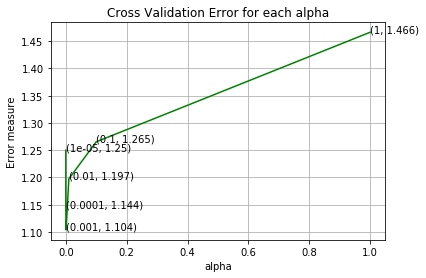

For values of best alpha =  0.001 The train log loss is: 0.6178072849254355
For values of best alpha =  0.001 The cross validation log loss is: 1.1013579118367638
For values of best alpha =  0.001 The test log loss is: 1.1197383476019258


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffle=True, tol=0.001,
                                         

In [0]:
params = {'penalty': 'l2', 'loss': 'log'}
generic_model_run(SGDClassifier, params, {'alpha': [10 ** x for x in range(-5, 1)]},\
                 train_text_feature_tfidf, y_train,\
                 cv_text_feature_tfidf, y_cv,\
                 test_text_feature_tfidf, y_test)

**Text feature with Tfidf vectorization is very good to classify the data with test loss = 1.12**

## OnehotCoding Models (Present in original notebook)

### Naive Bayes Model

For values of alpha =  1e-05 The log loss is: 1.2788108390808954
For values of alpha =  0.0001 The log loss is: 1.2781071286132668
For values of alpha =  0.001 The log loss is: 1.2612700579660445
For values of alpha =  0.1 The log loss is: 1.2231948603804161
For values of alpha =  1 The log loss is: 1.3010522661429493
For values of alpha =  10 The log loss is: 1.4024500835950684
For values of alpha =  100 The log loss is: 1.4058995203432123
For values of alpha =  1000 The log loss is: 1.4131970052776583


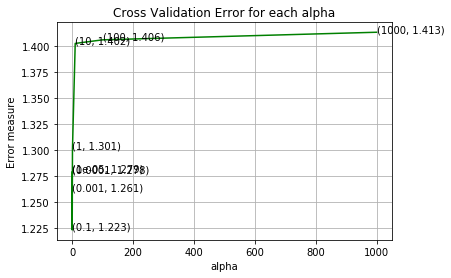

For values of best alpha =  0.1 The train log loss is: 0.8800398341934663
For values of best alpha =  0.1 The cross validation log loss is: 1.2231948603804161
For values of best alpha =  0.1 The test log loss is: 1.2365593833953286


In [0]:
nb_model_ohe = generic_model_run(MultinomialNB, {}, {'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]},\
                  train_x_onehotCoding, y_train,\
                  cv_x_onehotCoding, y_cv,\
                  test_x_onehotCoding, y_test)

Log Loss : 1.2365593833953286
Number of missclassified point : 0.37593984962406013
-------------------- Confusion matrix --------------------


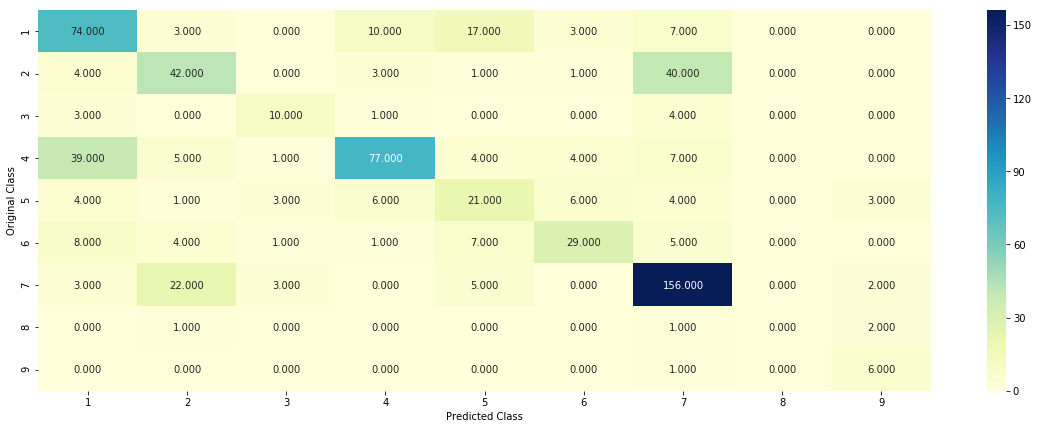

-------------------- Precision matrix (Columm Sum=1) --------------------


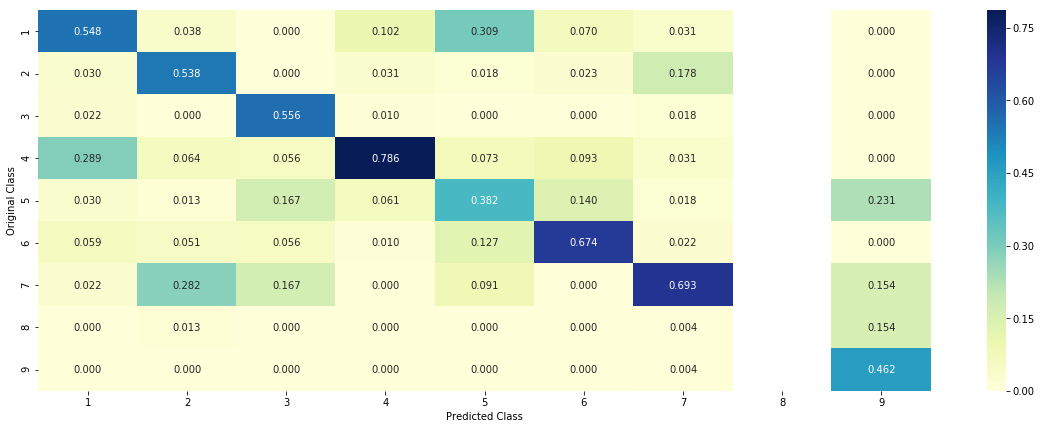

-------------------- Recall matrix (Row sum=1) --------------------


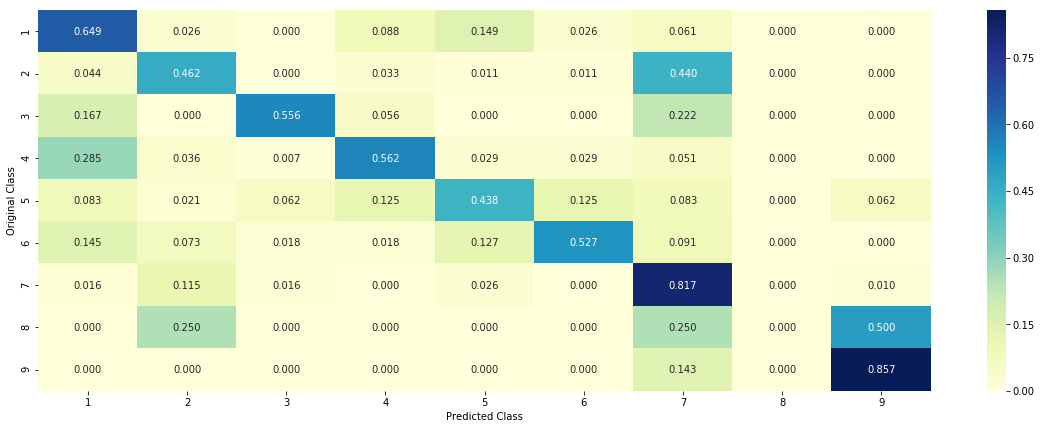

In [0]:
generic_best_model_result(nb_model_ohe, test_x_onehotCoding, y_test)

**Naive Bayes is not that good for classifying as the loss is higher than logistic regression with only title as feature.**

### K Nearest Neighbour Classifier

For values of n_neighbors =  5 The log loss is: 1.2276575618051355
For values of n_neighbors =  11 The log loss is: 1.2849380128937324
For values of n_neighbors =  15 The log loss is: 1.2727705720534588
For values of n_neighbors =  21 The log loss is: 1.3064496593998844
For values of n_neighbors =  31 The log loss is: 1.368234062423428
For values of n_neighbors =  41 The log loss is: 1.3706832385157746
For values of n_neighbors =  51 The log loss is: 1.3274386189987462
For values of n_neighbors =  99 The log loss is: 1.3176460957442968


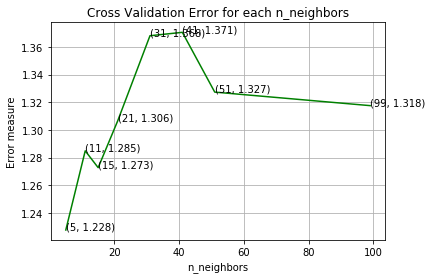

For values of best n_neighbors =  5 The train log loss is: 1.0241864670582843
For values of best n_neighbors =  5 The cross validation log loss is: 1.2276575618051355
For values of best n_neighbors =  5 The test log loss is: 1.2729958218023785


In [0]:
knn_model_ohe = generic_model_run(KNeighborsClassifier, {},\
                  {'n_neighbors': [5, 11, 15, 21, 31, 41, 51, 99]},\
                  train_x_onehotCoding, y_train,\
                  cv_x_onehotCoding, y_cv,\
                  test_x_onehotCoding, y_test)

Log Loss : 1.2729958218023785
Number of missclassified point : 0.42255639097744363
-------------------- Confusion matrix --------------------


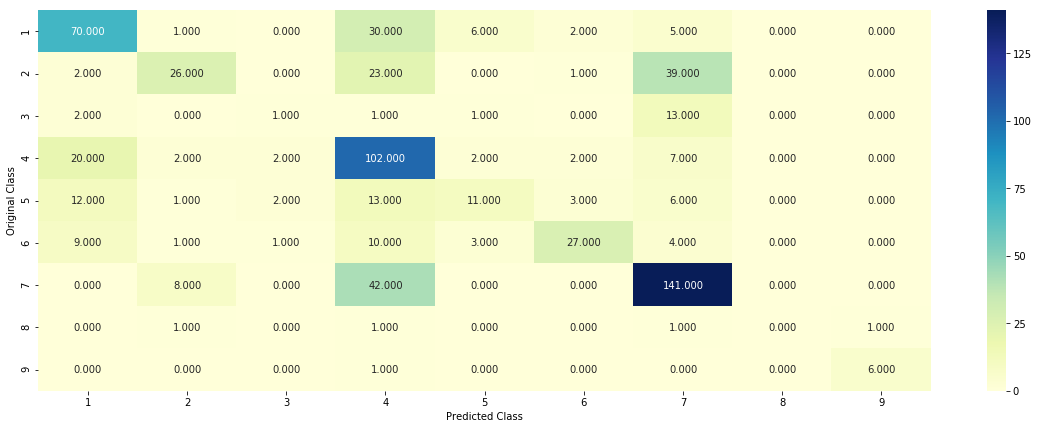

-------------------- Precision matrix (Columm Sum=1) --------------------


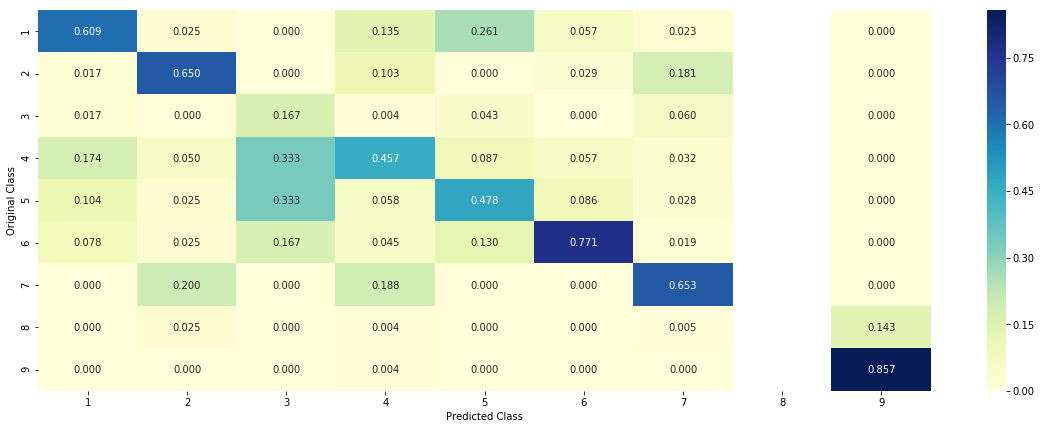

-------------------- Recall matrix (Row sum=1) --------------------


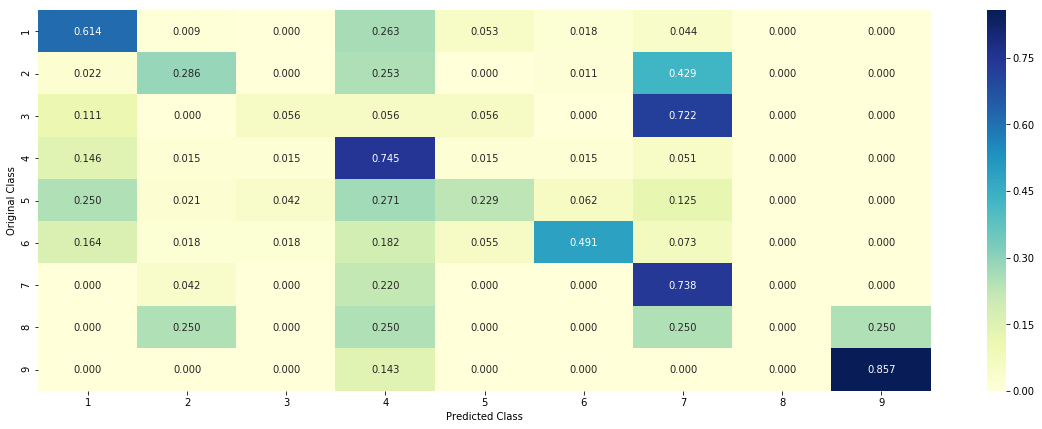

In [0]:
generic_best_model_result(knn_model_ohe, test_x_onehotCoding, y_test)

**KNN is also not good either as it is also not better than previous model with only title feature**

### Logistic Regression with class balancing

For values of alpha =  1e-06 The log loss is: 1.3540872373592623
For values of alpha =  1e-05 The log loss is: 1.295345573646939
For values of alpha =  0.0001 The log loss is: 1.148468968995796
For values of alpha =  0.001 The log loss is: 1.1192567186931752
For values of alpha =  0.01 The log loss is: 1.168156499974418
For values of alpha =  0.1 The log loss is: 1.4589798815038626
For values of alpha =  1 The log loss is: 1.7137765424107596
For values of alpha =  10 The log loss is: 1.7493866077707902
For values of alpha =  100 The log loss is: 1.7537446795873775


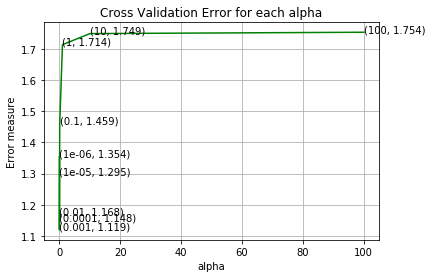

For values of best alpha =  0.001 The train log loss is: 0.5616627320453548
For values of best alpha =  0.001 The cross validation log loss is: 1.0940238337923078
For values of best alpha =  0.001 The test log loss is: 1.0868271653569335


In [0]:
params = {'class_weight': 'balanced', 'penalty': 'l2', 'loss': 'log'}
lr_model_ohe = generic_model_run(SGDClassifier, params,\
                  {'alpha': [10 ** x for x in range(-6, 3)]},\
                  train_x_onehotCoding, y_train,\
                  cv_x_onehotCoding, y_cv,\
                  test_x_onehotCoding, y_test)

Log Loss : 1.0868271653569335
Number of missclassified point : 0.3518796992481203
-------------------- Confusion matrix --------------------


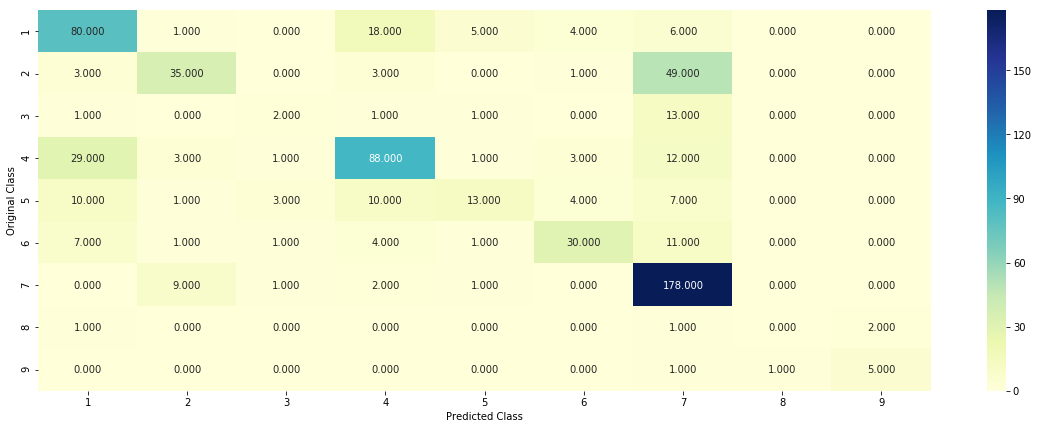

-------------------- Precision matrix (Columm Sum=1) --------------------


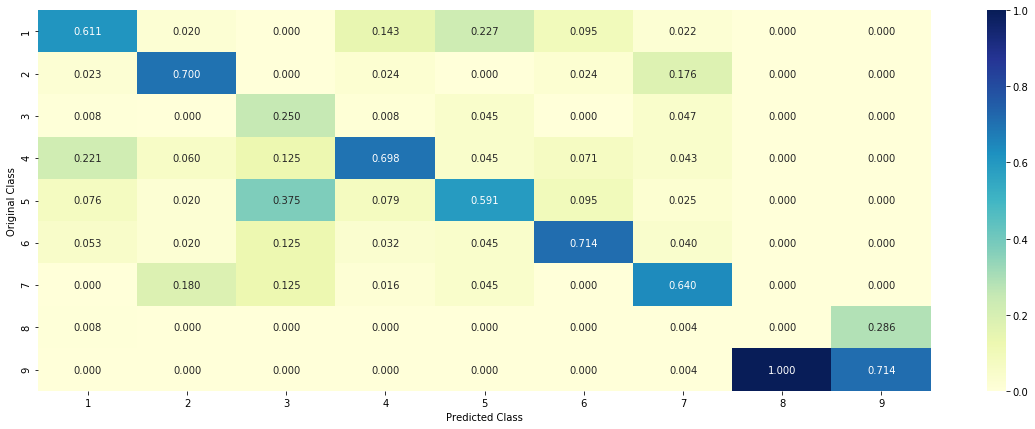

-------------------- Recall matrix (Row sum=1) --------------------


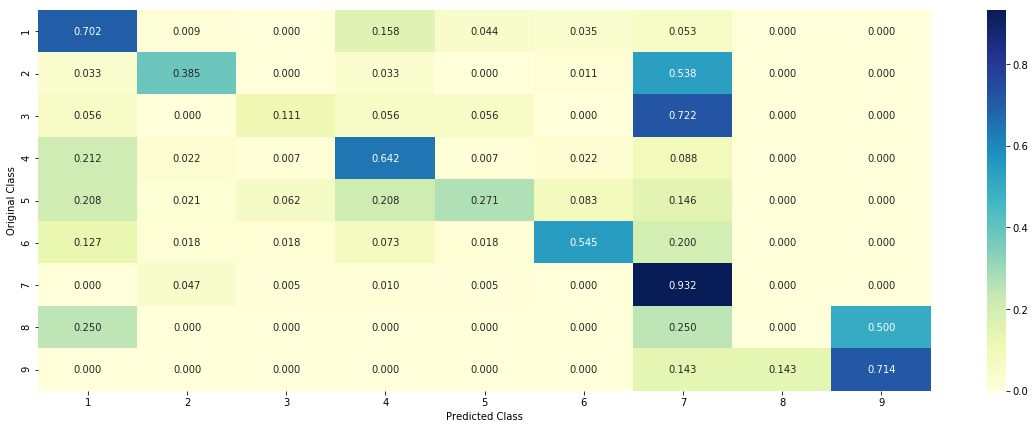

In [0]:
generic_best_model_result(lr_model_ohe, test_x_onehotCoding, y_test)

**By far best model but difference in log-loss for this model and model with only text feature is not that big. New improved log-loss = 1.08 and miss-classification rate of 35.18%**

### Logistic Regression without class balancing

For values of alpha =  1e-06 The log loss is: 1.347819289901216
For values of alpha =  1e-05 The log loss is: 1.3197738675517203
For values of alpha =  0.0001 The log loss is: 1.1858204653140139
For values of alpha =  0.001 The log loss is: 1.1652374798360234
For values of alpha =  0.01 The log loss is: 1.2743702163916097
For values of alpha =  0.1 The log loss is: 1.3217742472802991
For values of alpha =  1 The log loss is: 1.5154664816581391
For values of alpha =  10 The log loss is: 1.5635545267611515
For values of alpha =  100 The log loss is: 1.5690520283577654


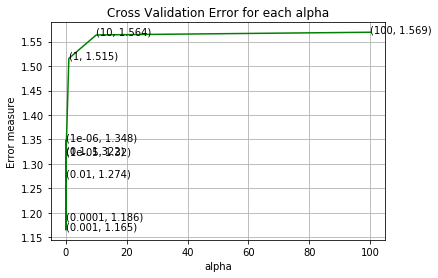

For values of best alpha =  0.001 The train log loss is: 0.5671964921736881
For values of best alpha =  0.001 The cross validation log loss is: 1.15952515198214
For values of best alpha =  0.001 The test log loss is: 1.1063735481504213


In [0]:
params = {'penalty': 'l2', 'loss': 'log'}
lr_ub_model_ohe = generic_model_run(SGDClassifier, params,\
                  {'alpha': [10 ** x for x in range(-6, 3)]},\
                  train_x_onehotCoding, y_train,\
                  cv_x_onehotCoding, y_cv,\
                  test_x_onehotCoding, y_test)

Log Loss : 1.1063735481504213
Number of missclassified point : 0.3548872180451128
-------------------- Confusion matrix --------------------


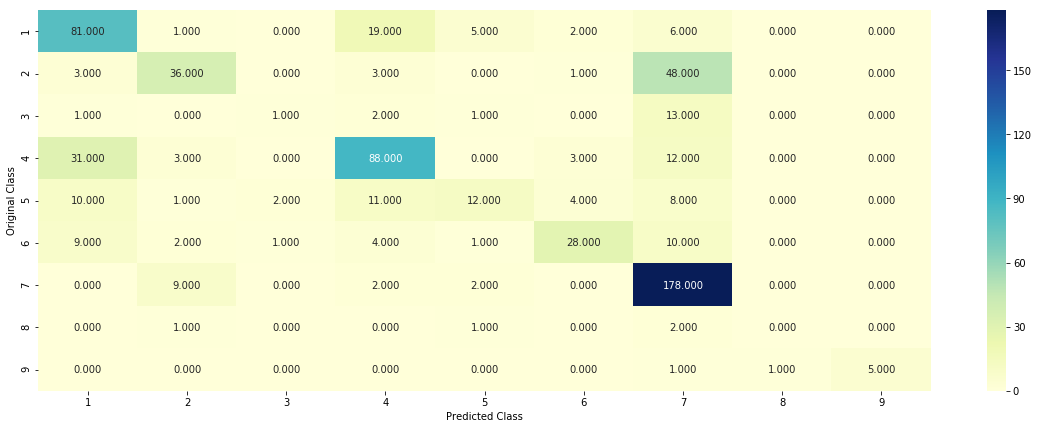

-------------------- Precision matrix (Columm Sum=1) --------------------


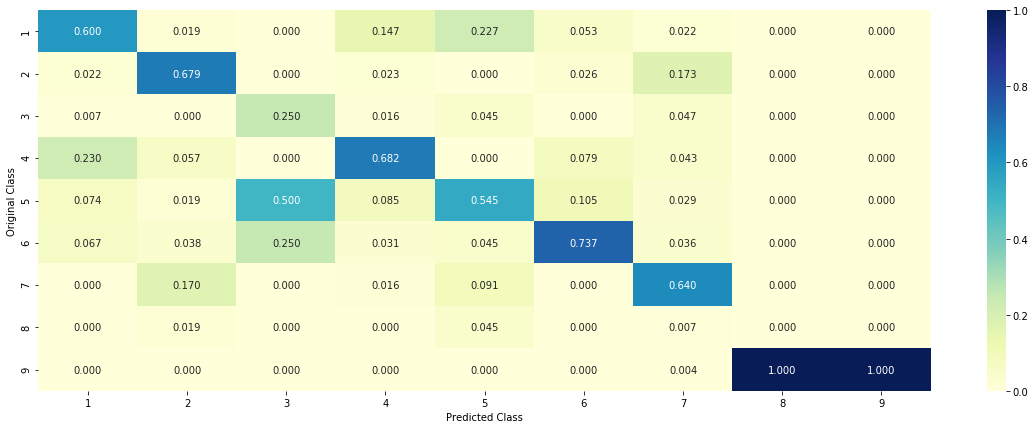

-------------------- Recall matrix (Row sum=1) --------------------


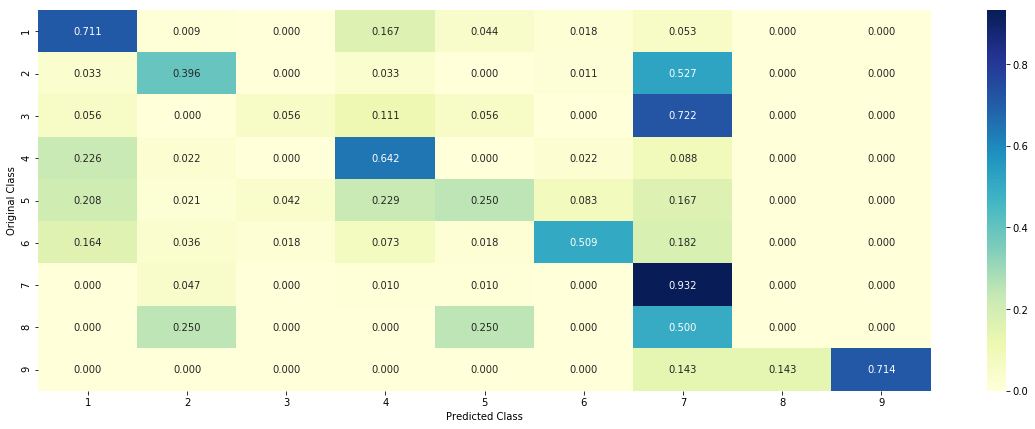

In [0]:
generic_best_model_result(lr_ub_model_ohe, test_x_onehotCoding, y_test)

**Logistic Regression without balancing is not better than model with balancing but better than other previous models.**

### Linear Support Vector Machines with balancing

For values of alpha =  1e-05 The log loss is: 1.3267395152442105
For values of alpha =  0.0001 The log loss is: 1.245554293756088
For values of alpha =  0.001 The log loss is: 1.101645305464791
For values of alpha =  0.01 The log loss is: 1.120958906604671
For values of alpha =  0.1 The log loss is: 1.3408248448380864
For values of alpha =  1 The log loss is: 1.7268107086341469
For values of alpha =  10 The log loss is: 1.754452609600292
For values of alpha =  100 The log loss is: 1.7544489324565629


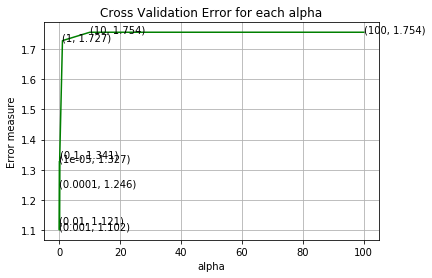

For values of best alpha =  0.001 The train log loss is: 0.5729865750120118
For values of best alpha =  0.001 The cross validation log loss is: 1.1031186339019554
For values of best alpha =  0.001 The test log loss is: 1.1241525706960536


In [0]:
params = {'class_weight': 'balanced', 'penalty': 'l2', 'loss': 'hinge'}
lsvm_model_ohe = generic_model_run(SGDClassifier, params,\
                  {'alpha': [10 ** x for x in range(-5, 3)]},\
                  train_x_onehotCoding, y_train,\
                  cv_x_onehotCoding, y_cv,\
                  test_x_onehotCoding, y_test)

Log Loss : 1.1241525706960536
Number of missclassified point : 0.3383458646616541
-------------------- Confusion matrix --------------------


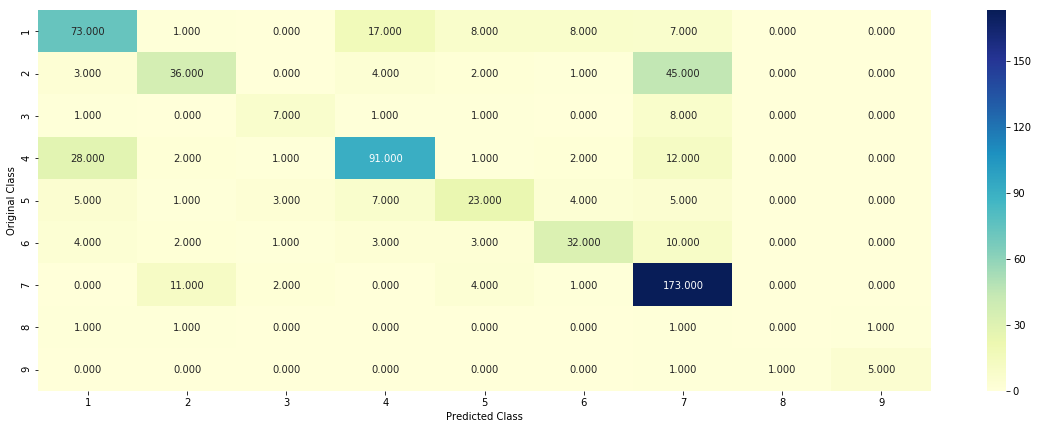

-------------------- Precision matrix (Columm Sum=1) --------------------


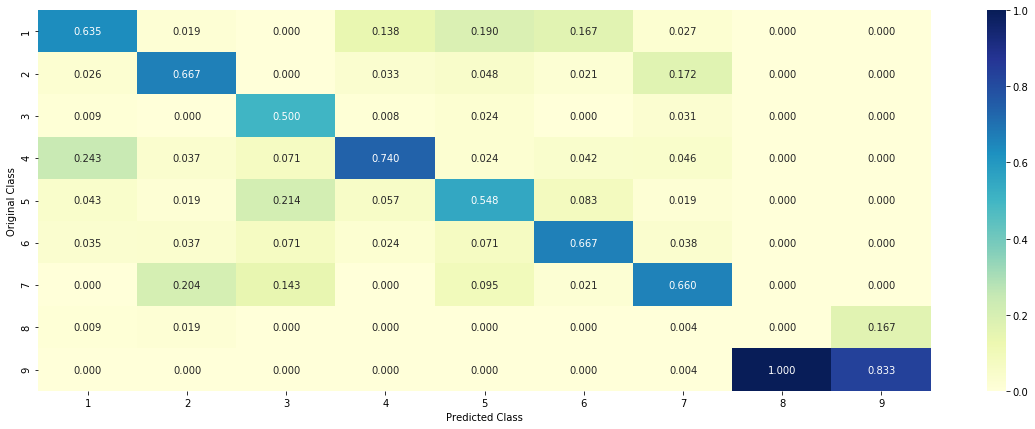

-------------------- Recall matrix (Row sum=1) --------------------


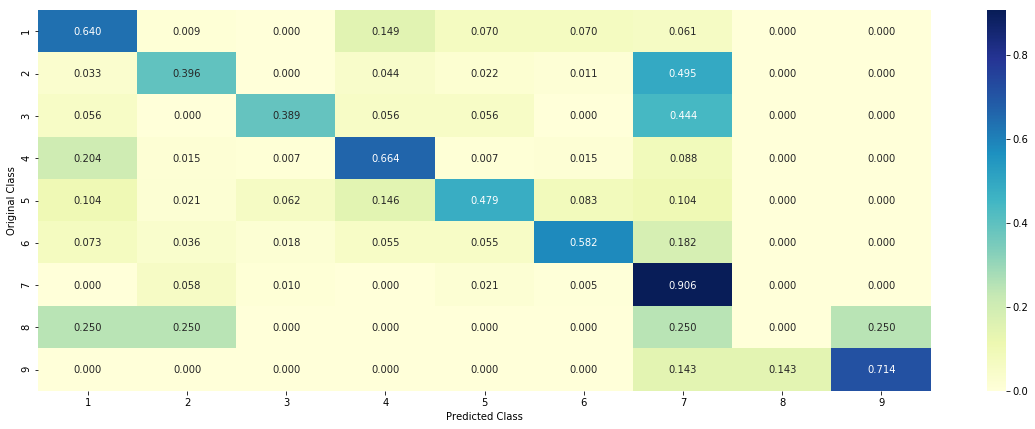

In [0]:
generic_best_model_result(lsvm_model_ohe, test_x_onehotCoding, y_test)

**Linear SVM 's log-loss is not better than logistic regression models but accuracy is good as miss-classified data points are 33.83% which is by far the best.**

### Linear Support Vector Machines without class balancing

For values of alpha =  1e-05 The log loss is: 1.315142632247362
For values of alpha =  0.0001 The log loss is: 1.258737566234368
For values of alpha =  0.001 The log loss is: 1.131009930201176
For values of alpha =  0.01 The log loss is: 1.1270417417387164
For values of alpha =  0.1 The log loss is: 1.3307839311412957
For values of alpha =  1 The log loss is: 1.5457698332112801
For values of alpha =  10 The log loss is: 1.5701279199630749
For values of alpha =  100 The log loss is: 1.5701278830713925


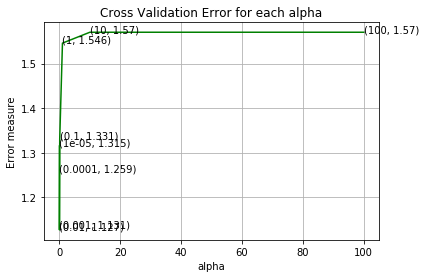

For values of best alpha =  0.01 The train log loss is: 0.7250970527956365
For values of best alpha =  0.01 The cross validation log loss is: 1.1307511265249268
For values of best alpha =  0.01 The test log loss is: 1.1555421797565182


In [0]:
params = {'penalty': 'l2', 'loss': 'hinge'}
lsvm_ub_model_ohe = generic_model_run(SGDClassifier, params,\
                  {'alpha': [10 ** x for x in range(-5, 3)]},\
                  train_x_onehotCoding, y_train,\
                  cv_x_onehotCoding, y_cv,\
                  test_x_onehotCoding, y_test)

Log Loss : 1.1555421797565182
Number of missclassified point : 0.35639097744360904
-------------------- Confusion matrix --------------------


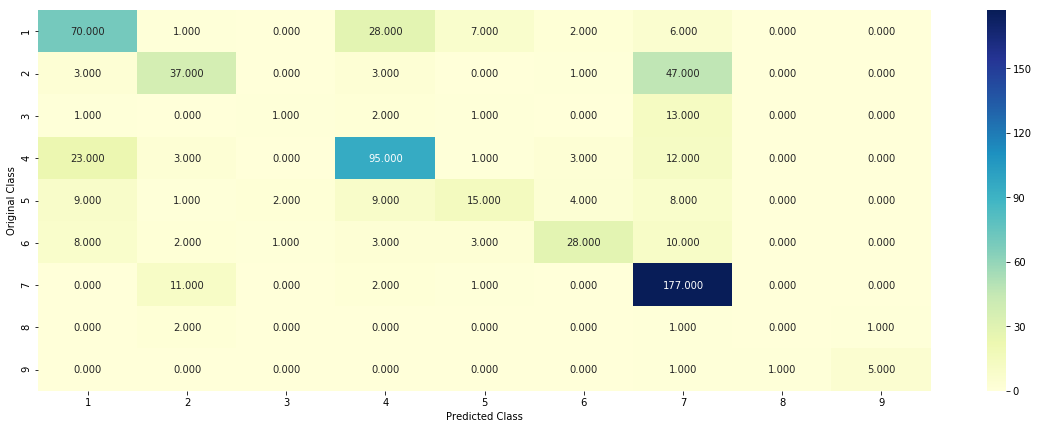

-------------------- Precision matrix (Columm Sum=1) --------------------


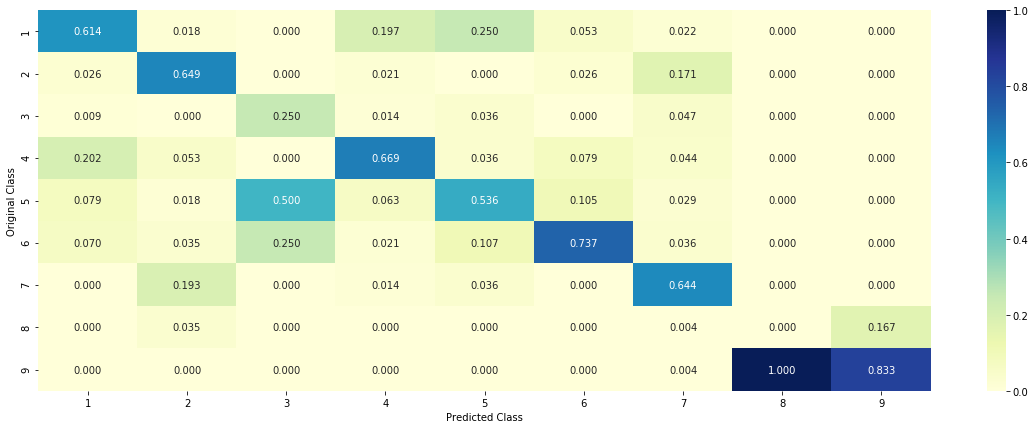

-------------------- Recall matrix (Row sum=1) --------------------


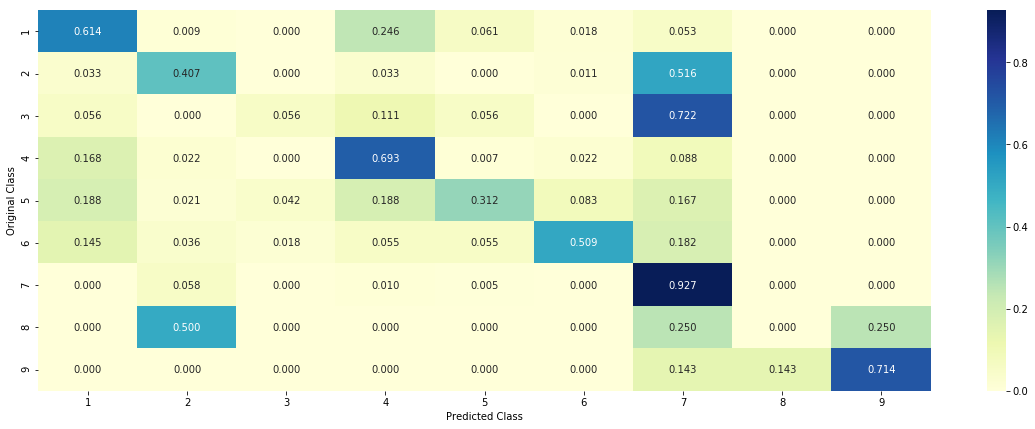

In [0]:
generic_best_model_result(lsvm_ub_model_ohe, test_x_onehotCoding, y_test)

**Linear SVM without balancing is not good than any other previous linear models. So in general unbalanced models are not good because logistic regression without balancing is also not good.**

### Random Forest Classifier

For values of n_estimators =  10 The log loss is: 1.319991269438926
For values of n_estimators =  50 The log loss is: 1.2224483819475727
For values of n_estimators =  100 The log loss is: 1.195770604877337
For values of n_estimators =  200 The log loss is: 1.1924247013538958
For values of n_estimators =  500 The log loss is: 1.1892958393724715
For values of n_estimators =  1000 The log loss is: 1.1859303713440645


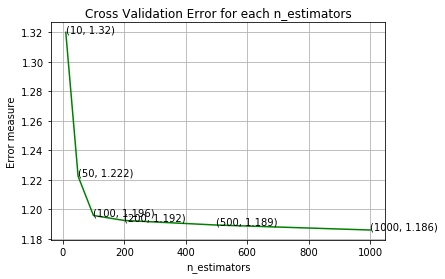

For values of best n_estimators =  1000 The train log loss is: 0.48132885750406584
For values of best n_estimators =  1000 The cross validation log loss is: 1.1866984778492522
For values of best n_estimators =  1000 The test log loss is: 1.171469284077797


In [0]:
params = {'criterion': 'gini', 'max_depth': 20, 'n_jobs': -1}
rf_model_ohe = generic_model_run(RandomForestClassifier, params,\
                  {'n_estimators': [10,50,100,200,500,1000]},\
                  train_x_onehotCoding, y_train,\
                  cv_x_onehotCoding, y_cv,\
                  test_x_onehotCoding, y_test)

Log Loss : 1.171469284077797
Number of missclassified point : 0.3804511278195489
-------------------- Confusion matrix --------------------


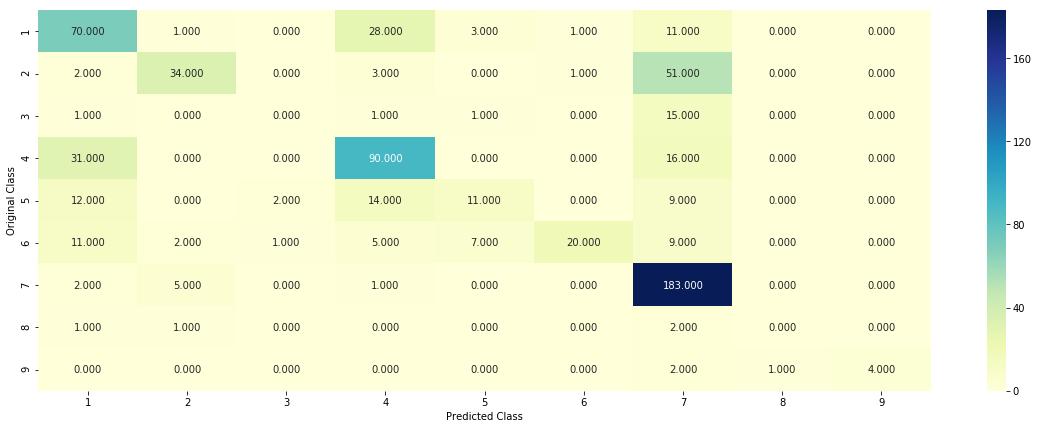

-------------------- Precision matrix (Columm Sum=1) --------------------


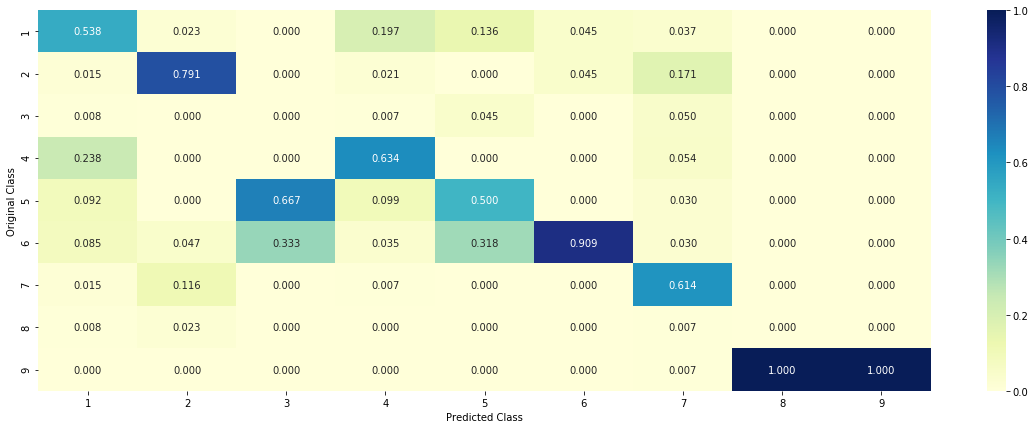

-------------------- Recall matrix (Row sum=1) --------------------


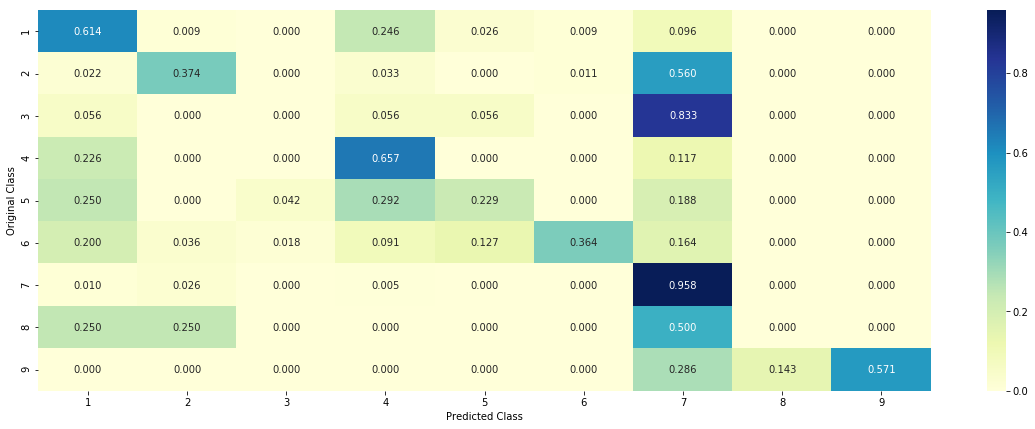

In [0]:
generic_best_model_result(rf_model_ohe, test_x_onehotCoding, y_test)

**Random forest models are expected to be not good because of high dimension data.**

### Random Forest with Response Coding data

For values of n_estimators =  10 The log loss is: 2.052827060351802
For values of n_estimators =  50 The log loss is: 1.9383526454205648
For values of n_estimators =  100 The log loss is: 1.928445002490143
For values of n_estimators =  200 The log loss is: 1.8155390661711603
For values of n_estimators =  500 The log loss is: 1.8973942291571992
For values of n_estimators =  1000 The log loss is: 1.843153317071527


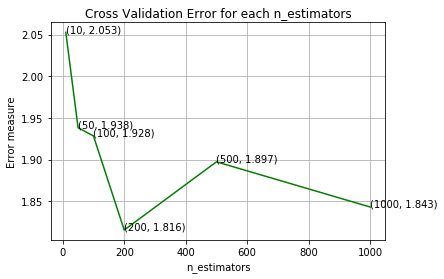

For values of best n_estimators =  200 The train log loss is: 0.03177485702968159
For values of best n_estimators =  200 The cross validation log loss is: 1.7975804488427811
For values of best n_estimators =  200 The test log loss is: 1.8085688593803435


In [0]:
params = {'criterion': 'gini', 'max_depth': 20, 'n_jobs': -1}
rf_rc_model_ohe = generic_model_run(RandomForestClassifier, params,\
                  {'n_estimators': [10,50,100,200,500,1000]},\
                  train_x_responseCoding, y_train,\
                  cv_x_responseCoding, y_cv,\
                  test_x_responseCoding, y_test)

Log Loss : 1.8085688593803435
Number of missclassified point : 0.6917293233082706
-------------------- Confusion matrix --------------------


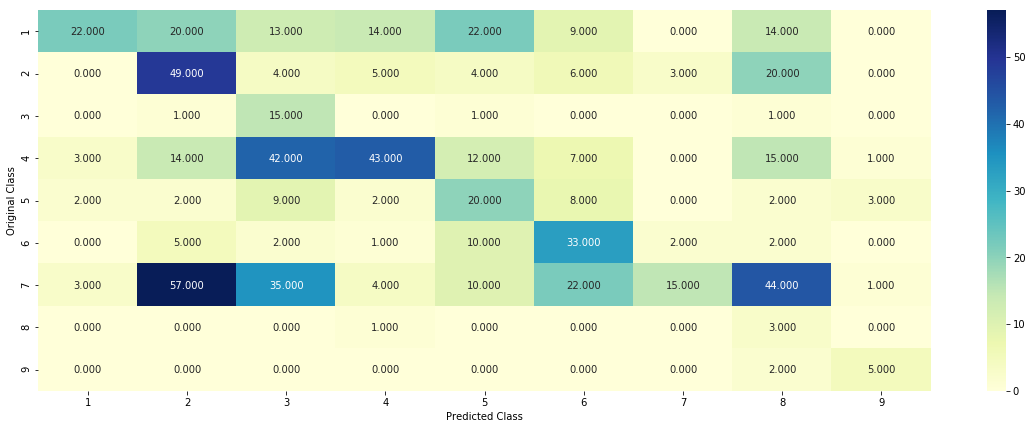

-------------------- Precision matrix (Columm Sum=1) --------------------


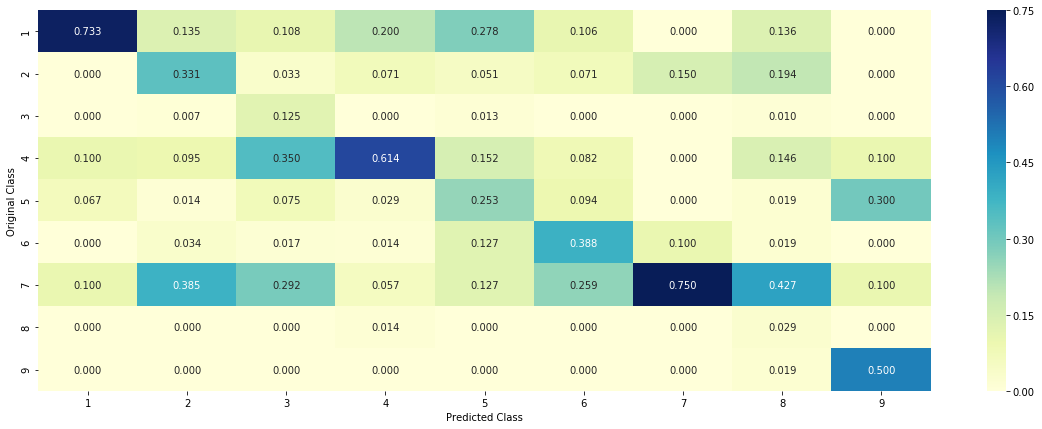

-------------------- Recall matrix (Row sum=1) --------------------


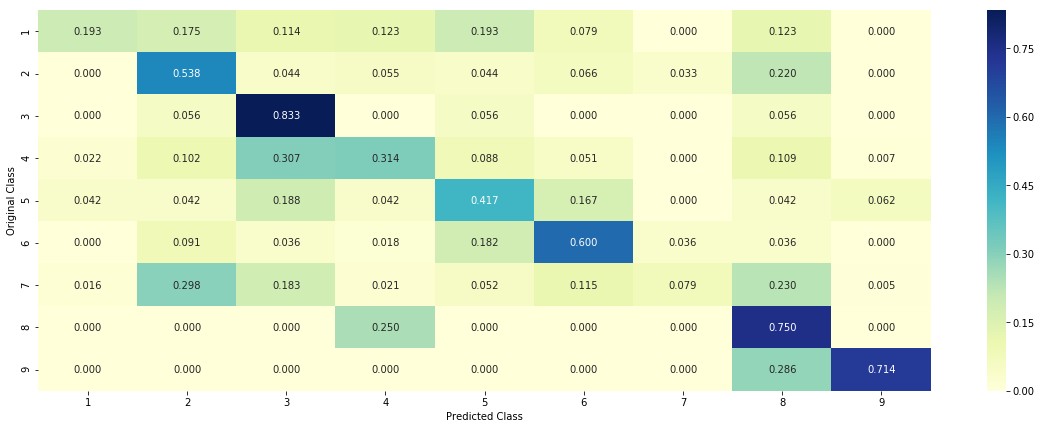

In [0]:
generic_best_model_result(rf_rc_model_ohe, test_x_responseCoding, y_test)

**Random forest model with responce coding is tried as random forest models are good with less dimensions but this model did very bad as log-loss is nearly equal to dummy classifier which is used at start. So response coding features may not be good for our classification task.**

### Stacked Models

**We can use models above to train the stacked model.**

Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.173
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.997
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.423
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.077
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.140
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.290
Log loss (train) on the stacking classifier : 0.42394809999081406
Log loss (CV) on the stacking classifier : 1.0769000763793206
Log loss (test) on the stacking classifier : 1.0987262072712187
Number of missclassified point : 0.34135338345864663
-------------------- Confusion matrix --------------------


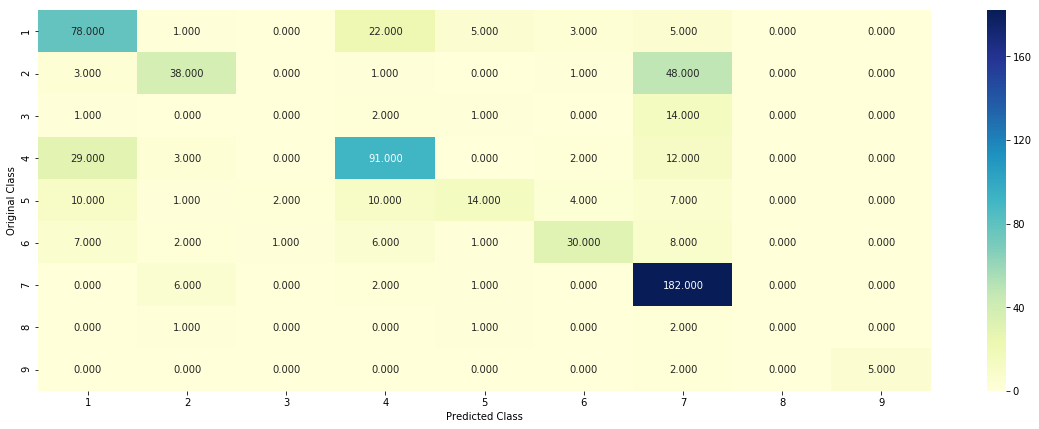

-------------------- Precision matrix (Columm Sum=1) --------------------


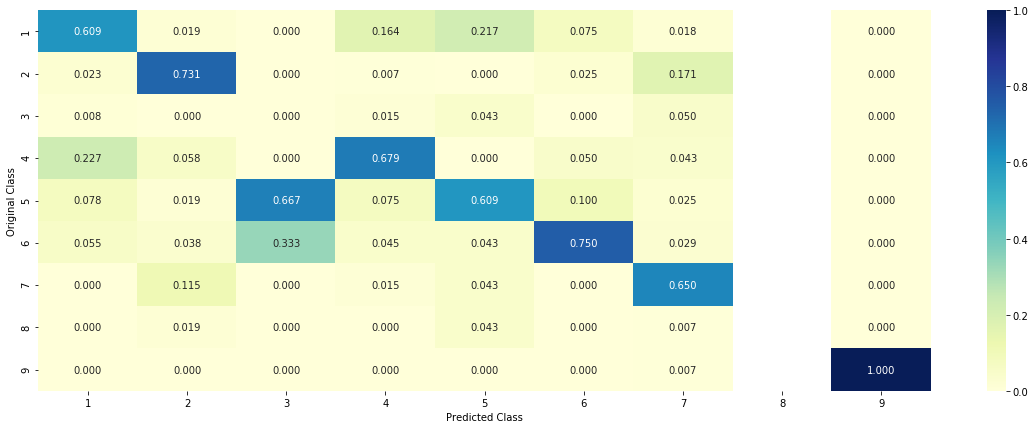

-------------------- Recall matrix (Row sum=1) --------------------


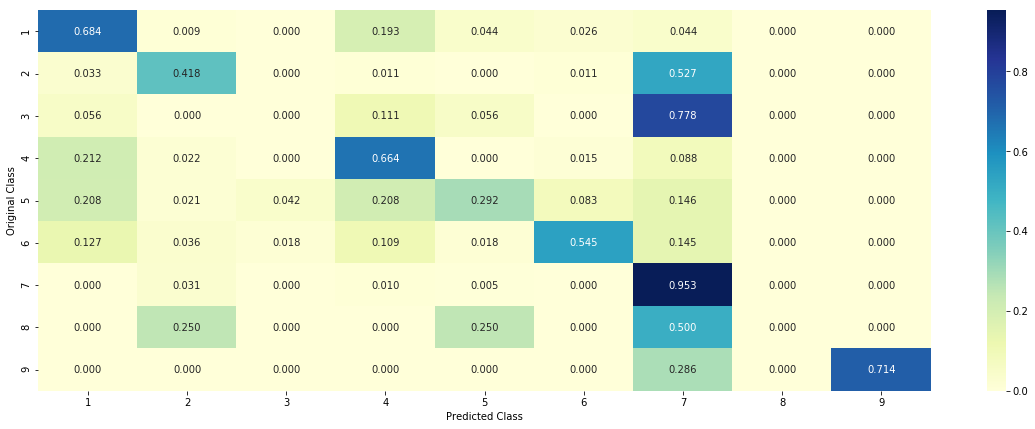

In [107]:
classifiers = [lr_model_ohe, lsvm_model_ohe, rf_model_ohe]

alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_loss = 999
best_alpha = -1
best_model = None
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=classifiers, meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_error))
    if best_loss > log_error:
        best_loss = log_error
        best_alpha = i
        best_model = sclf

log_error = log_loss(train_y, best_model.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, best_model.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, best_model.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((best_model.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=best_model.predict(test_x_onehotCoding))

stacked_models_ohe = best_model

**Stacked model is not as good as individual models. So it is better to use individual models.**

## Assignments

<ol>
    <li> Apply All the models with tf-idf features (Replace CountVectorizer with tfidfVectorizer and run the same cells)</li>
    <li> Instead of using all the words in the dataset, use only the top 1000 words based of tf-idf values</li>
    <li>Apply Logistic regression with CountVectorizer Features, including both unigrams and bigrams</li>
    <li> Try any of the feature engineering techniques discussed in the course to reduce the CV and test log-loss to a value less than 1.0</li>
</ol>

## Models with TfIdf Encoded data

### Naive Bayes Model

For values of alpha =  1e-05 The log loss is: 1.2730946720781628
For values of alpha =  0.0001 The log loss is: 1.2678720740469156
For values of alpha =  0.001 The log loss is: 1.2499163620919178
For values of alpha =  0.1 The log loss is: 1.2211526274657072
For values of alpha =  1 The log loss is: 1.2568595719561708
For values of alpha =  10 The log loss is: 1.3089812656063535
For values of alpha =  100 The log loss is: 1.2695218625075577
For values of alpha =  1000 The log loss is: 1.2347660184059757


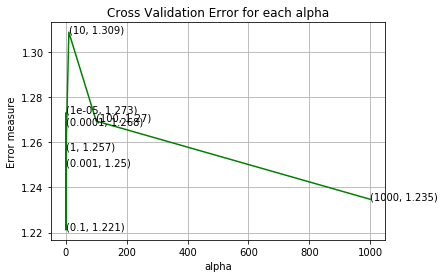

For values of best alpha =  0.1 The train log loss is: 0.8669439196126353
For values of best alpha =  0.1 The cross validation log loss is: 1.2211526274657072
For values of best alpha =  0.1 The test log loss is: 1.2545435909686284


In [0]:
nb_model_tfidf = generic_model_run(MultinomialNB, {}, {'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]},\
                  train_x_tfidf, y_train,\
                  cv_x_tfidf, y_cv,\
                  test_x_tfidf, y_test)

Log Loss : 1.2545435909686284
Number of missclassified point : 0.3774436090225564
-------------------- Confusion matrix --------------------


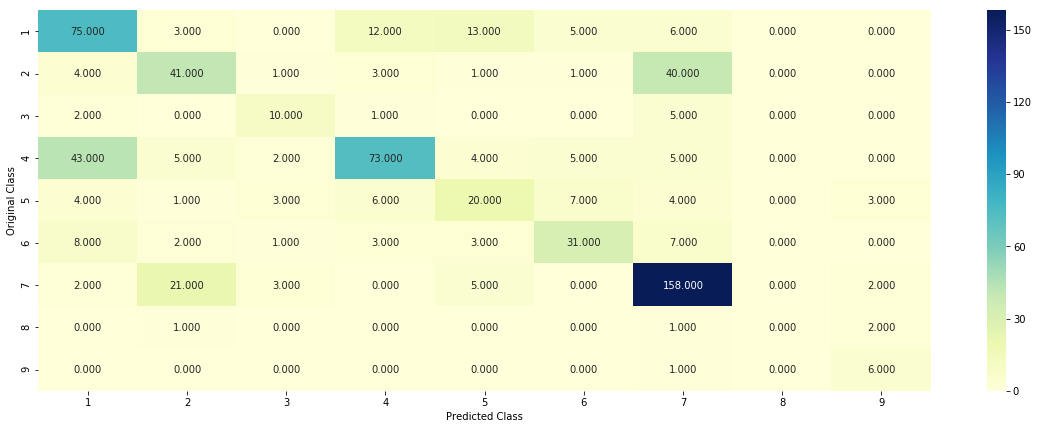

-------------------- Precision matrix (Columm Sum=1) --------------------


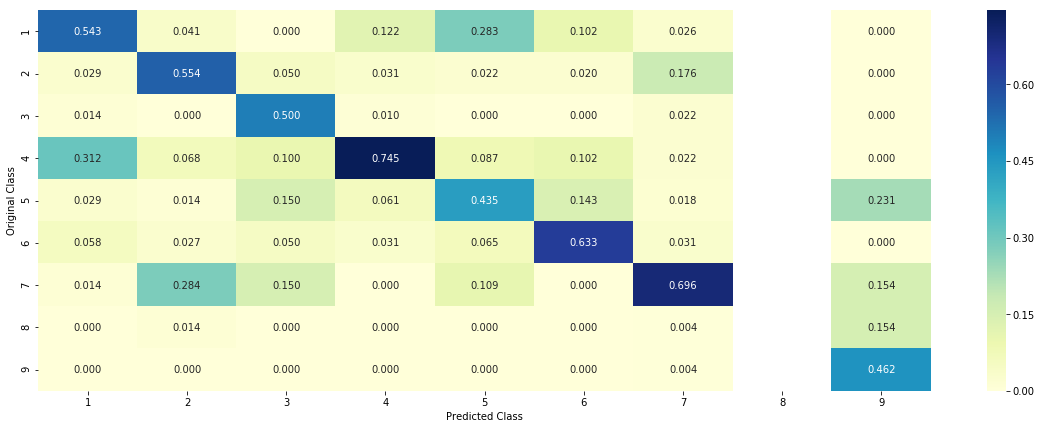

-------------------- Recall matrix (Row sum=1) --------------------


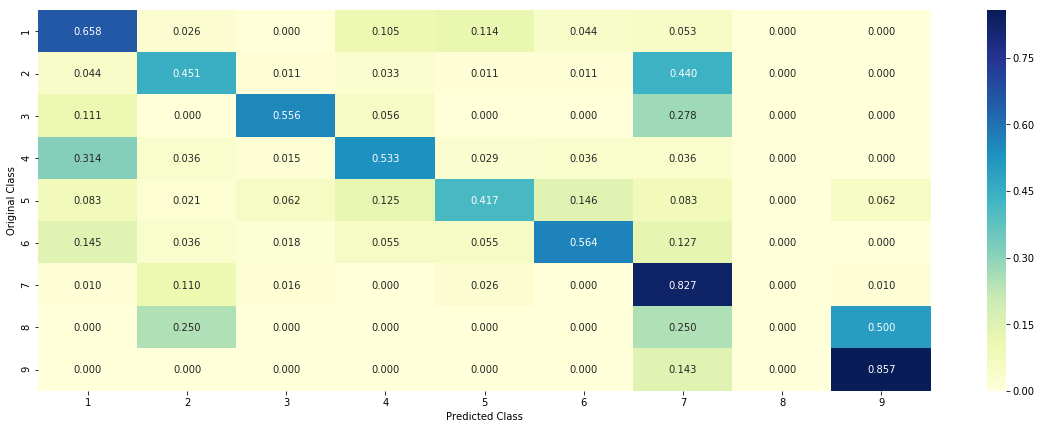

In [0]:
generic_best_model_result(nb_model_tfidf, test_x_tfidf, y_test)

**Naive bayes model is not good even with tfidf features.**

### K Nearest Neighbour Classifier

For values of n_neighbors =  5 The log loss is: 1.2414632907289451
For values of n_neighbors =  11 The log loss is: 1.313502954900308
For values of n_neighbors =  15 The log loss is: 1.363628284945309
For values of n_neighbors =  21 The log loss is: 1.391682512731897
For values of n_neighbors =  31 The log loss is: 1.424233787954708
For values of n_neighbors =  41 The log loss is: 1.4561601058919904
For values of n_neighbors =  51 The log loss is: 1.4528679377136597
For values of n_neighbors =  99 The log loss is: 1.342409355916611


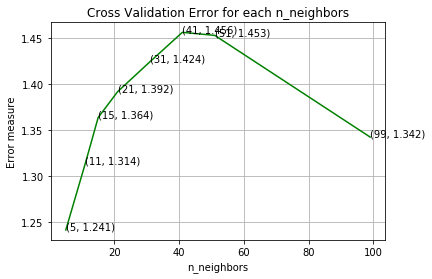

For values of best n_neighbors =  5 The train log loss is: 1.0062213310451678
For values of best n_neighbors =  5 The cross validation log loss is: 1.2414632907289451
For values of best n_neighbors =  5 The test log loss is: 1.3008152230187822


In [0]:
knn_model_tfidf = generic_model_run(KNeighborsClassifier, {},\
                  {'n_neighbors': [5, 11, 15, 21, 31, 41, 51, 99]},\
                  train_x_tfidf, y_train,\
                  cv_x_tfidf, y_cv,\
                  test_x_tfidf, y_test)

Log Loss : 1.3008152230187822
Number of missclassified point : 0.4345864661654135
-------------------- Confusion matrix --------------------


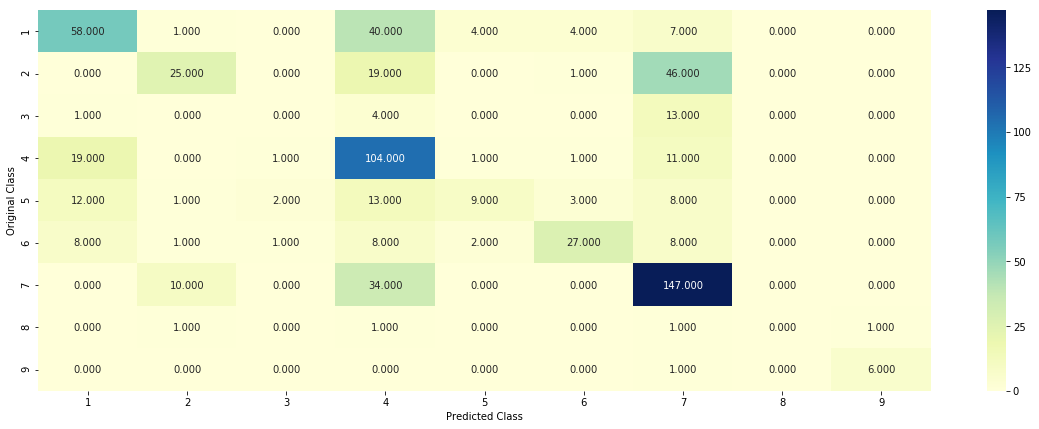

-------------------- Precision matrix (Columm Sum=1) --------------------


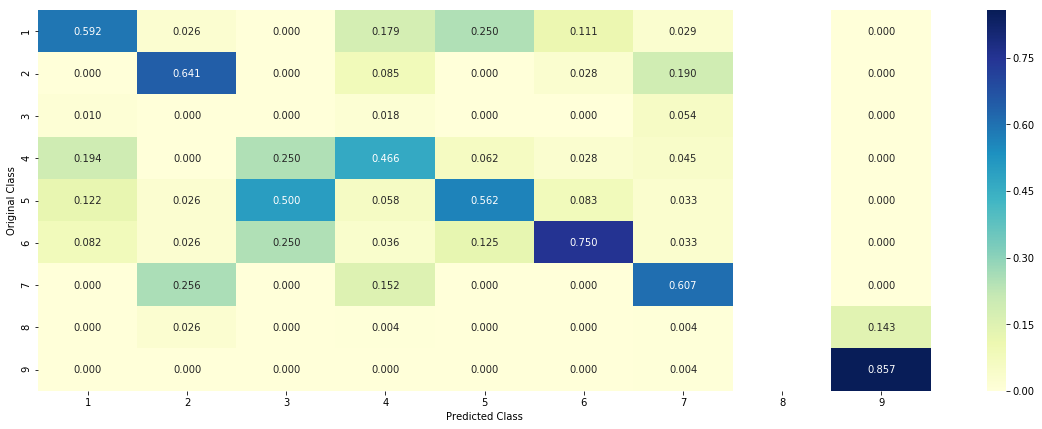

-------------------- Recall matrix (Row sum=1) --------------------


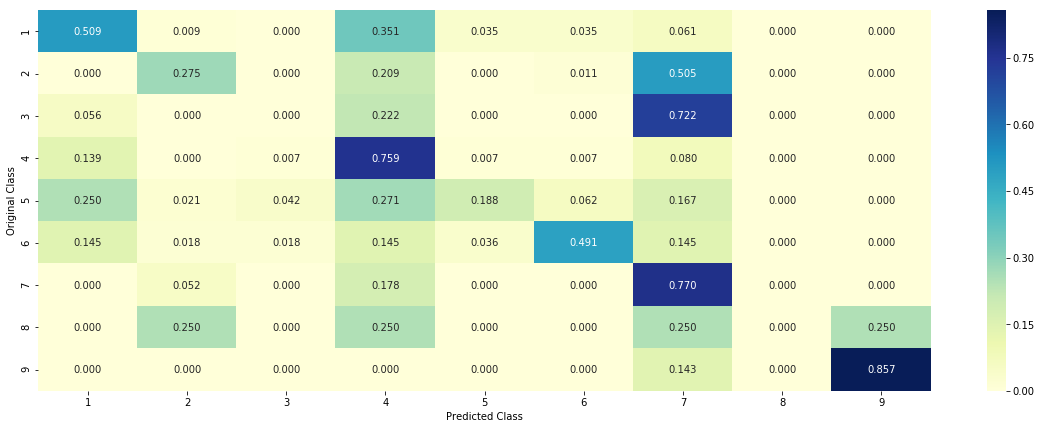

In [0]:
generic_best_model_result(knn_model_tfidf, test_x_tfidf, y_test)

**This KNN model did bad than previous KNN model with count vectorization.**

### Logistic Regression with class balancing

For values of alpha =  1e-06 The log loss is: 1.3362130349829031
For values of alpha =  1e-05 The log loss is: 1.2490042705180808
For values of alpha =  0.0001 The log loss is: 1.1021954102404043
For values of alpha =  0.001 The log loss is: 1.0357527027082487
For values of alpha =  0.01 The log loss is: 1.0630141885950262
For values of alpha =  0.1 The log loss is: 1.1786205841976363
For values of alpha =  1 The log loss is: 1.4051087369977073
For values of alpha =  10 The log loss is: 1.4520117646155357
For values of alpha =  100 The log loss is: 1.4574805146015406


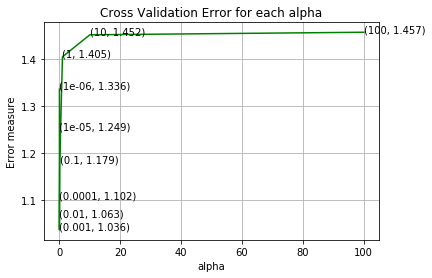

For values of best alpha =  0.001 The train log loss is: 0.525253684358903
For values of best alpha =  0.001 The cross validation log loss is: 1.0323727709463073
For values of best alpha =  0.001 The test log loss is: 1.0492385922807097


In [0]:
params = {'class_weight': 'balanced', 'penalty': 'l2', 'loss': 'log'}
lr_model_tfidf = generic_model_run(SGDClassifier, params,\
                  {'alpha': [10 ** x for x in range(-6, 3)]},\
                  train_x_tfidf, y_train,\
                  cv_x_tfidf, y_cv,\
                  test_x_tfidf, y_test)

Log Loss : 1.0492385922807097
Number of missclassified point : 0.362406015037594
-------------------- Confusion matrix --------------------


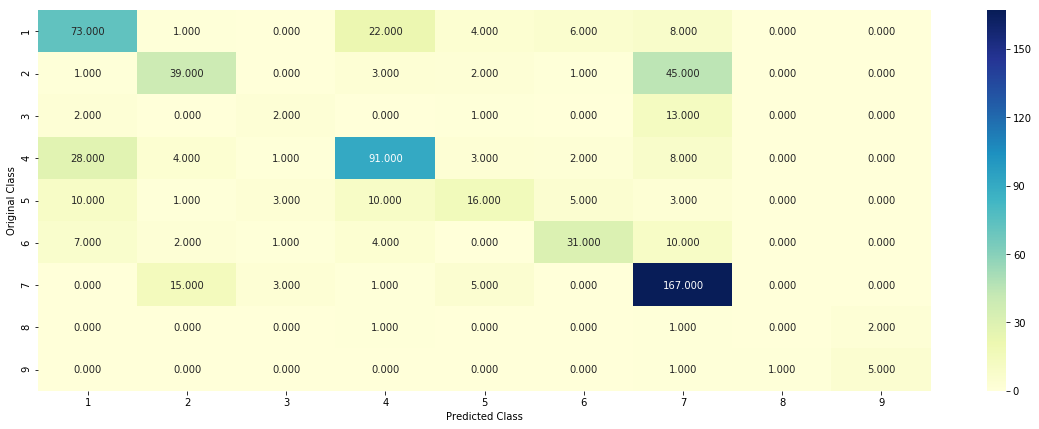

-------------------- Precision matrix (Columm Sum=1) --------------------


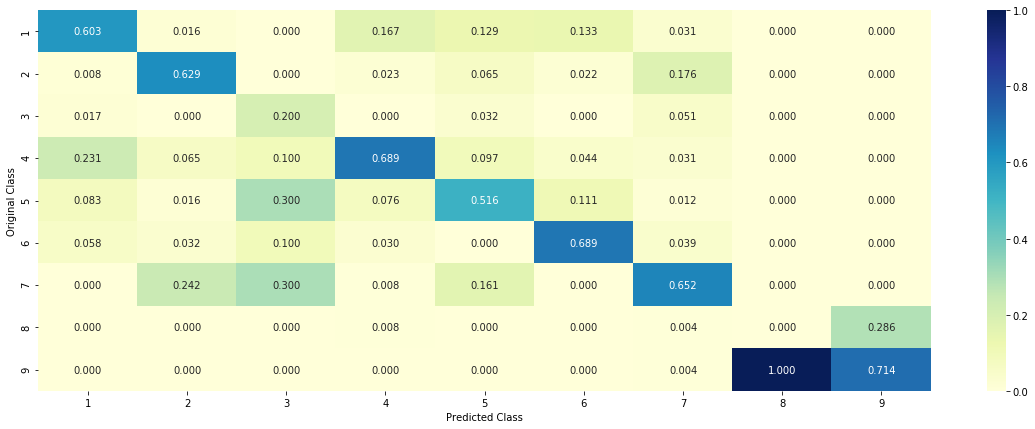

-------------------- Recall matrix (Row sum=1) --------------------


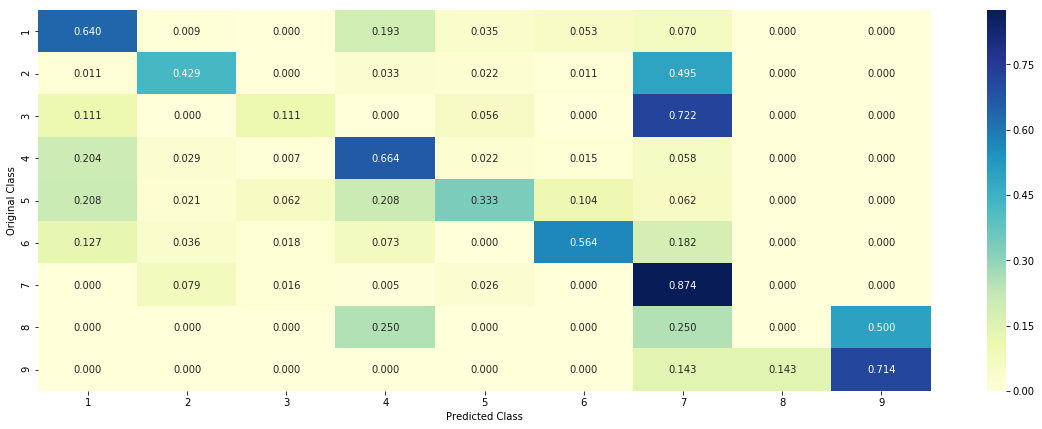

In [0]:
generic_best_model_result(lr_model_tfidf, test_x_tfidf, y_test)

**This Logistic Regression model did better than previous model and has by far best log-loss (test) = 1.05**

### Logistic Regression without class balancing

For values of alpha =  1e-06 The log loss is: 1.3144886270143865
For values of alpha =  1e-05 The log loss is: 1.2436591859434352
For values of alpha =  0.0001 The log loss is: 1.1214922445832496
For values of alpha =  0.001 The log loss is: 1.0596771940218865
For values of alpha =  0.01 The log loss is: 1.137755591046502
For values of alpha =  0.1 The log loss is: 1.2100474479981598
For values of alpha =  1 The log loss is: 1.4101143813812071
For values of alpha =  10 The log loss is: 1.4660801174488352
For values of alpha =  100 The log loss is: 1.4724496395046431


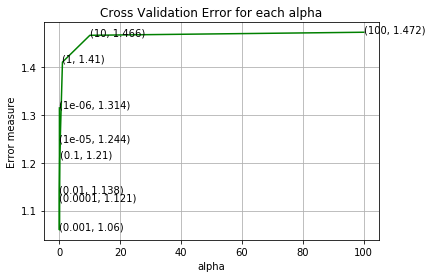

For values of best alpha =  0.001 The train log loss is: 0.5247078704032262
For values of best alpha =  0.001 The cross validation log loss is: 1.060244853123353
For values of best alpha =  0.001 The test log loss is: 1.067768264427037


In [0]:
params = {'penalty': 'l2', 'loss': 'log'}
lr_ub_model_tfidf = generic_model_run(SGDClassifier, params,\
                  {'alpha': [10 ** x for x in range(-6, 3)]},\
                  train_x_tfidf, y_train,\
                  cv_x_tfidf, y_cv,\
                  test_x_tfidf, y_test)

Log Loss : 1.067768264427037
Number of missclassified point : 0.3609022556390977
-------------------- Confusion matrix --------------------


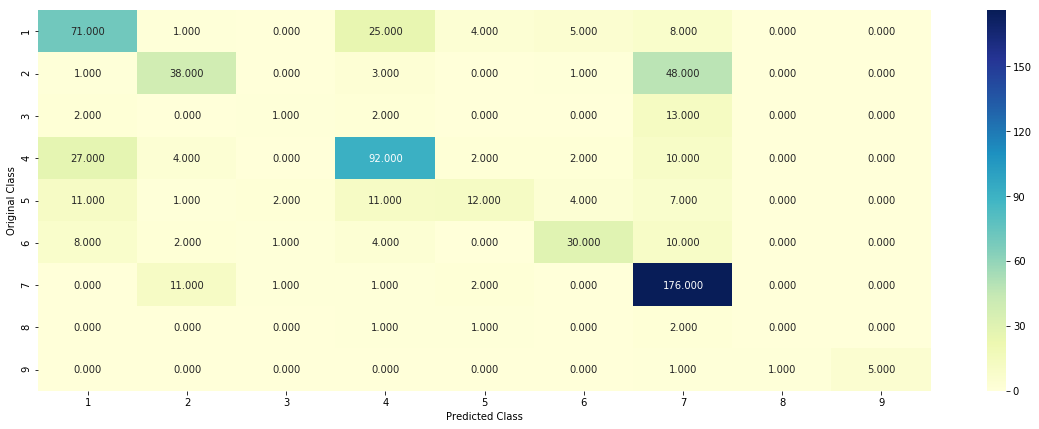

-------------------- Precision matrix (Columm Sum=1) --------------------


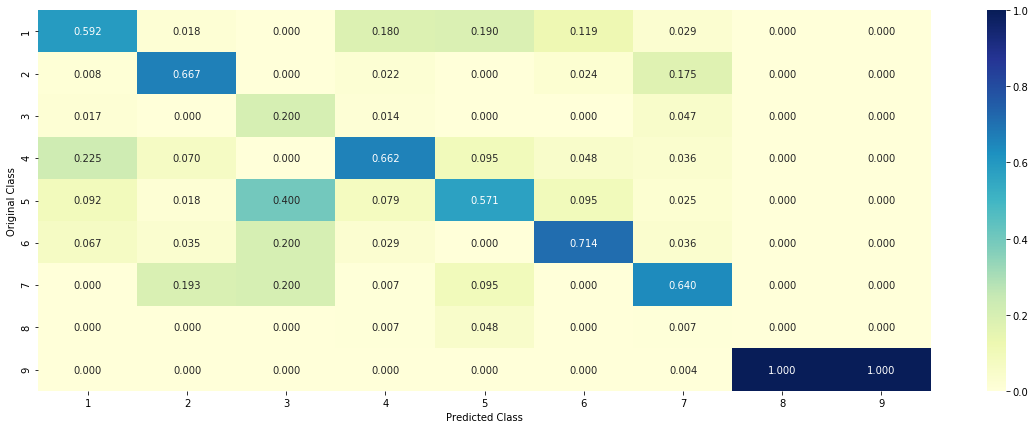

-------------------- Recall matrix (Row sum=1) --------------------


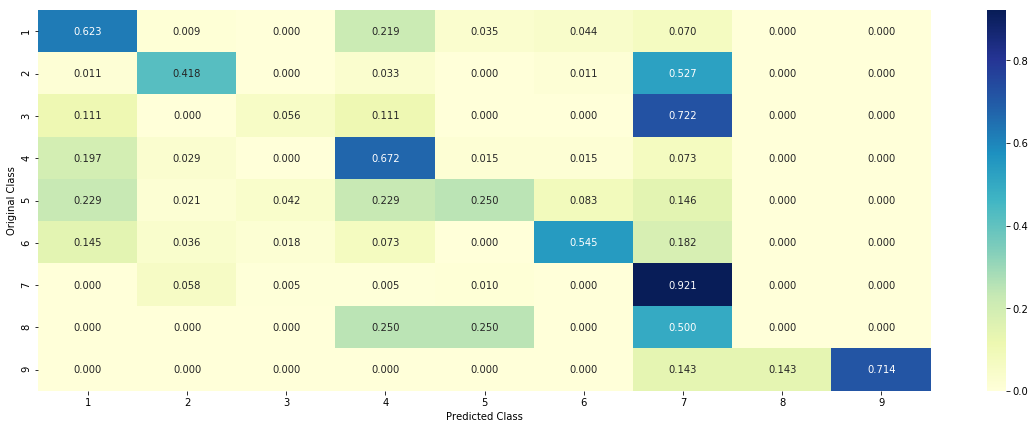

In [0]:
generic_best_model_result(lr_ub_model_tfidf, test_x_tfidf, y_test)

**Logisitic Regression without balancing also did better than previous models except the last one which is best.**

### Linear Support Vector Machines with balancing

For values of alpha =  1e-05 The log loss is: 1.3249273332613871
For values of alpha =  0.0001 The log loss is: 1.2230450075320123
For values of alpha =  0.001 The log loss is: 1.0666939129380058
For values of alpha =  0.01 The log loss is: 1.0987003703882854
For values of alpha =  0.1 The log loss is: 1.1491490179876707
For values of alpha =  1 The log loss is: 1.4581077442847008
For values of alpha =  10 The log loss is: 1.4581261757266901
For values of alpha =  100 The log loss is: 1.4581261878510692


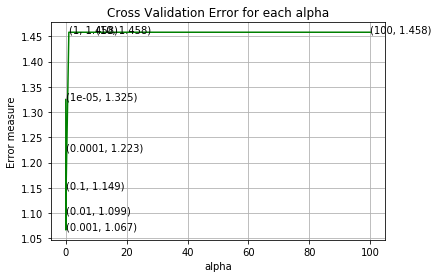

For values of best alpha =  0.001 The train log loss is: 0.5611812432155957
For values of best alpha =  0.001 The cross validation log loss is: 1.0790572290635194
For values of best alpha =  0.001 The test log loss is: 1.1010908389162197


In [0]:
params = {'class_weight': 'balanced', 'penalty': 'l2', 'loss': 'hinge'}
lsvm_model_tfidf = generic_model_run(SGDClassifier, params,\
                  {'alpha': [10 ** x for x in range(-5, 3)]},\
                  train_x_tfidf, y_train,\
                  cv_x_tfidf, y_cv,\
                  test_x_tfidf, y_test)

Log Loss : 1.1010908389162197
Number of missclassified point : 0.35789473684210527
-------------------- Confusion matrix --------------------


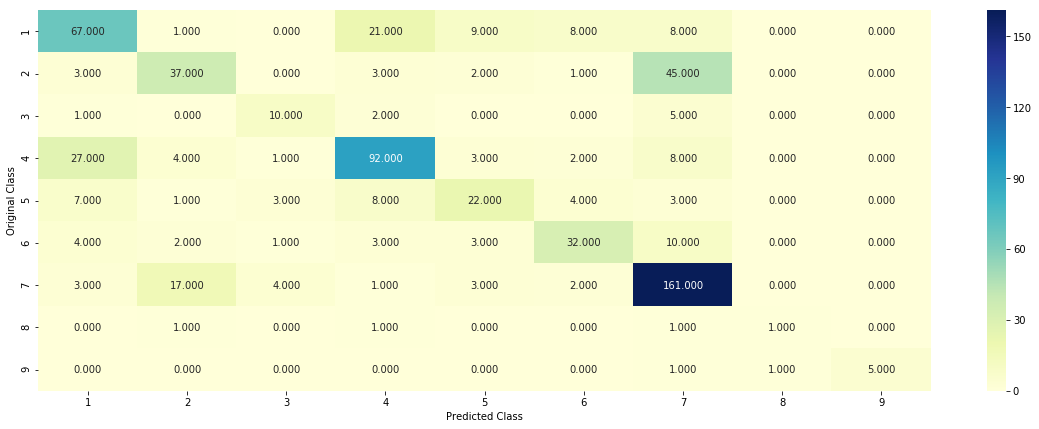

-------------------- Precision matrix (Columm Sum=1) --------------------


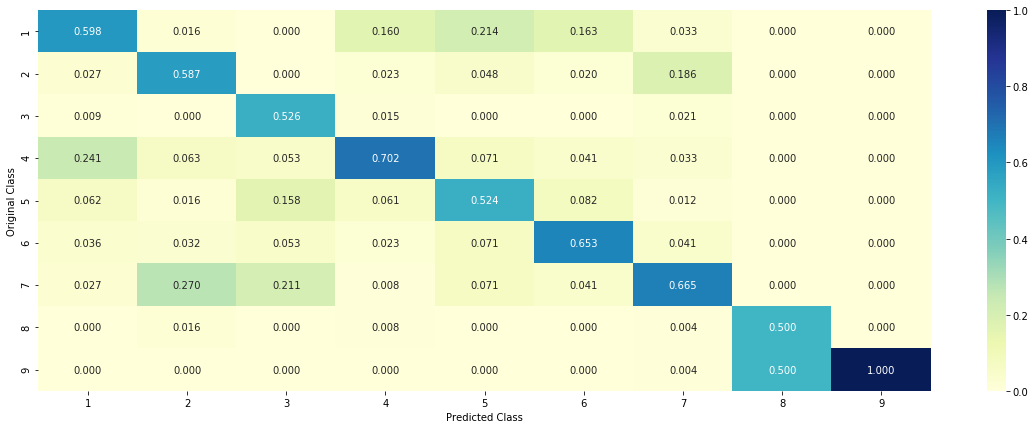

-------------------- Recall matrix (Row sum=1) --------------------


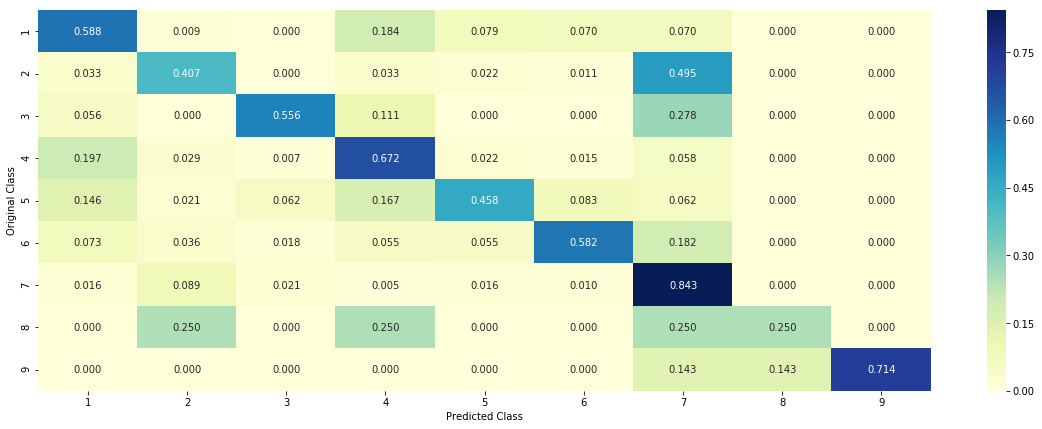

In [0]:
generic_best_model_result(lsvm_model_tfidf, test_x_tfidf, y_test)

**Linear SVM is not better than Logistic Regression and has similar results to previous Linear SVM model with count vectorizer.**

### Linear Support Vector Machines without class balancing

For values of alpha =  1e-05 The log loss is: 1.3039743823767618
For values of alpha =  0.0001 The log loss is: 1.1934501514802427
For values of alpha =  0.001 The log loss is: 1.0635309819088128
For values of alpha =  0.01 The log loss is: 1.073694055627291
For values of alpha =  0.1 The log loss is: 1.2181040169795037
For values of alpha =  1 The log loss is: 1.4739146338087403
For values of alpha =  10 The log loss is: 1.473533104168649
For values of alpha =  100 The log loss is: 1.4735330963067843


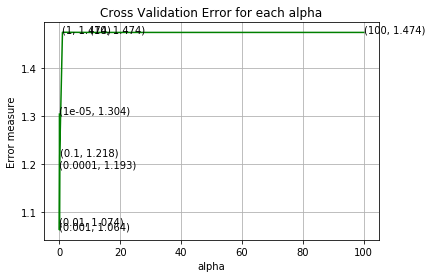

For values of best alpha =  0.001 The train log loss is: 0.5383690190080264
For values of best alpha =  0.001 The cross validation log loss is: 1.0538047660313707
For values of best alpha =  0.001 The test log loss is: 1.1183981006662362


In [0]:
params = {'penalty': 'l2', 'loss': 'hinge'}
lsvm_ub_model_tfidf = generic_model_run(SGDClassifier, params,\
                  {'alpha': [10 ** x for x in range(-5, 3)]},\
                  train_x_tfidf, y_train,\
                  cv_x_tfidf, y_cv,\
                  test_x_tfidf, y_test)

Log Loss : 1.1183981006662362
Number of missclassified point : 0.3593984962406015
-------------------- Confusion matrix --------------------


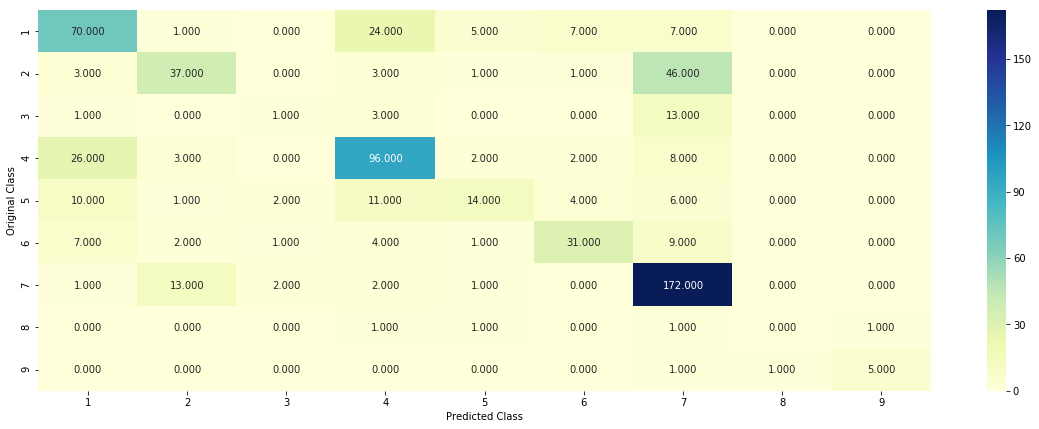

-------------------- Precision matrix (Columm Sum=1) --------------------


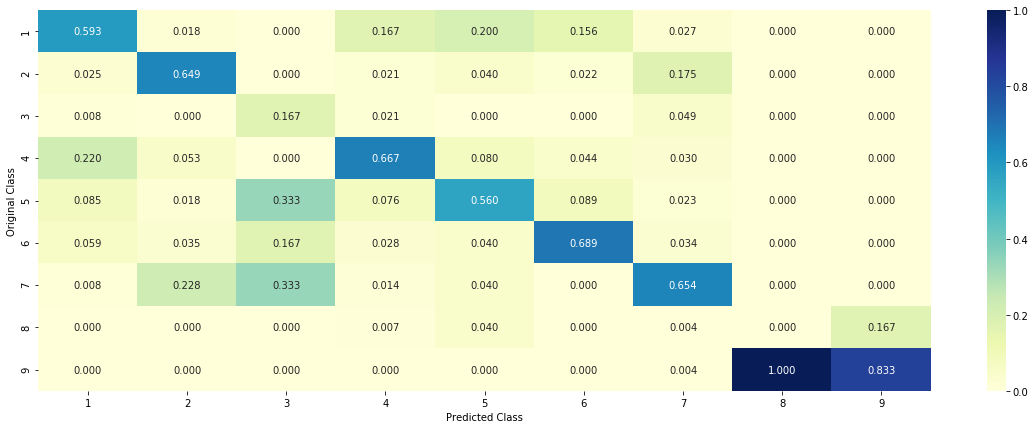

-------------------- Recall matrix (Row sum=1) --------------------


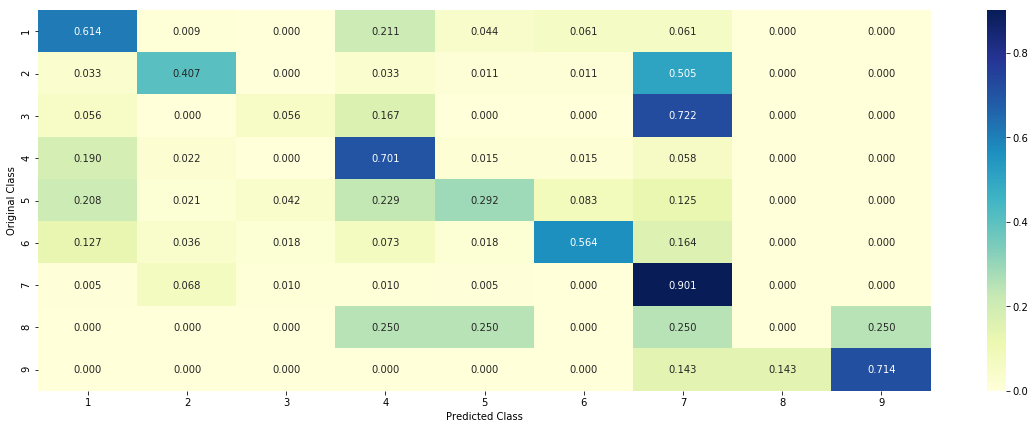

In [0]:
generic_best_model_result(lsvm_ub_model_tfidf, test_x_tfidf, y_test)

**No better results with Linear SVM model as data is not balanced.**

### Random Forest Classifier

For values of n_estimators =  10 The log loss is: 1.338449395651005
For values of n_estimators =  50 The log loss is: 1.2052983041662602
For values of n_estimators =  100 The log loss is: 1.195742730488182
For values of n_estimators =  200 The log loss is: 1.1844685557567125
For values of n_estimators =  500 The log loss is: 1.181001885942149
For values of n_estimators =  1000 The log loss is: 1.1761472031249784


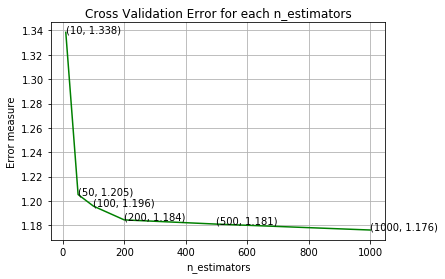

For values of best n_estimators =  1000 The train log loss is: 0.4718709796181661
For values of best n_estimators =  1000 The cross validation log loss is: 1.1768164801534742
For values of best n_estimators =  1000 The test log loss is: 1.201410868019007


In [0]:
params = {'criterion': 'gini', 'max_depth': 20, 'n_jobs': -1}
rf_model_tfidf = generic_model_run(RandomForestClassifier, params,\
                  {'n_estimators': [10,50,100,200,500,1000]},\
                  train_x_tfidf, y_train,\
                  cv_x_tfidf, y_cv,\
                  test_x_tfidf, y_test)

Log Loss : 1.201410868019007
Number of missclassified point : 0.4030075187969925
-------------------- Confusion matrix --------------------


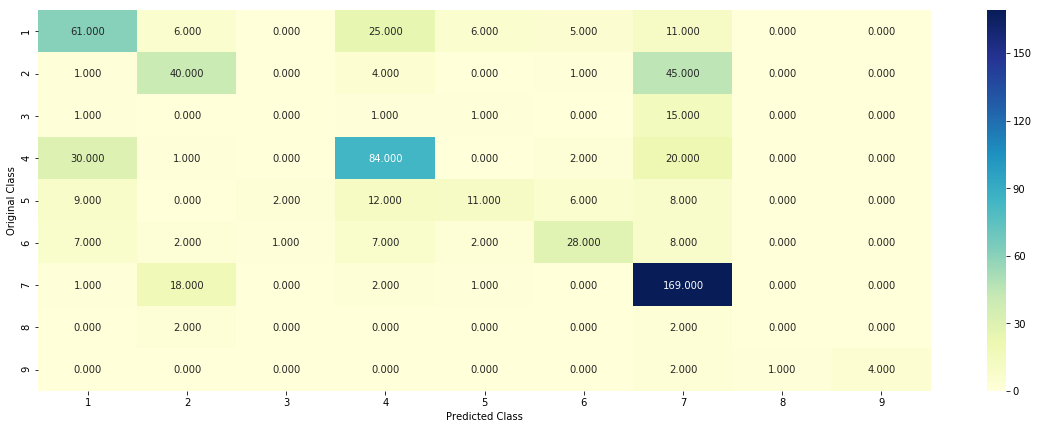

-------------------- Precision matrix (Columm Sum=1) --------------------


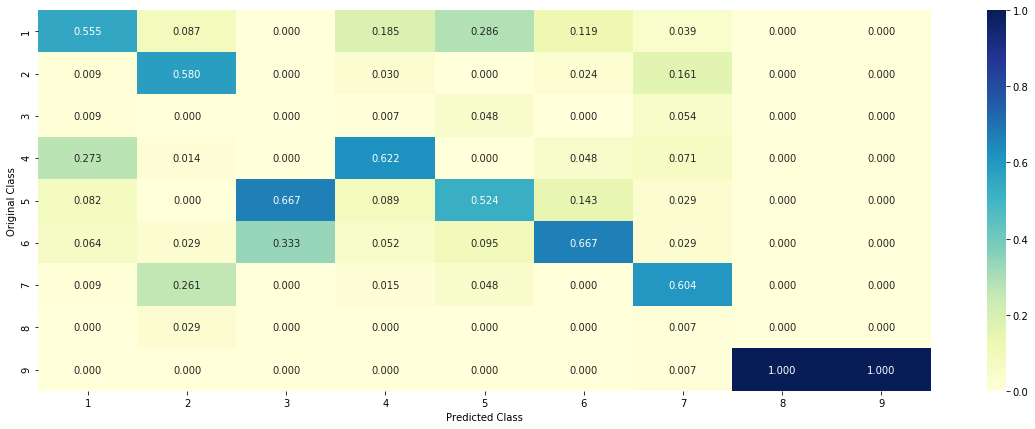

-------------------- Recall matrix (Row sum=1) --------------------


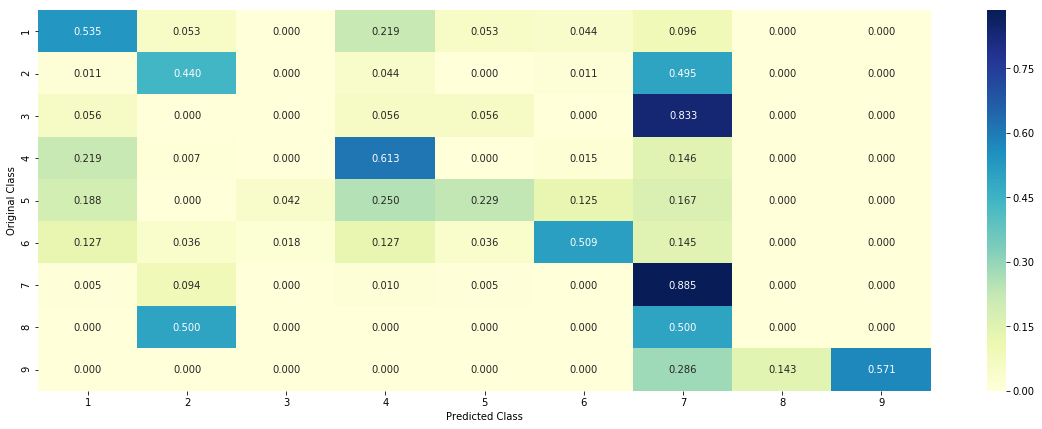

In [0]:
generic_best_model_result(rf_model_tfidf, test_x_tfidf, y_test)

**Again didnt do good as expected with tfidf features.**

### Stacked Models

Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.173
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.992
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.402
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.067
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.136
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.227
Log loss (train) on the stacking classifier : 0.40981178769326126
Log loss (CV) on the stacking classifier : 1.0667556400510778
Log loss (test) on the stacking classifier : 1.1158472796724723
Number of missclassified point : 0.3744360902255639
-------------------- Confusion matrix --------------------


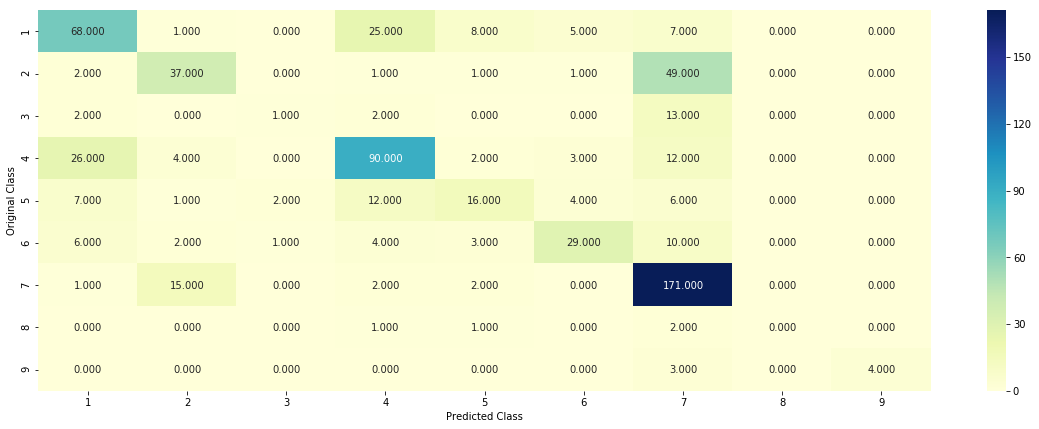

-------------------- Precision matrix (Columm Sum=1) --------------------


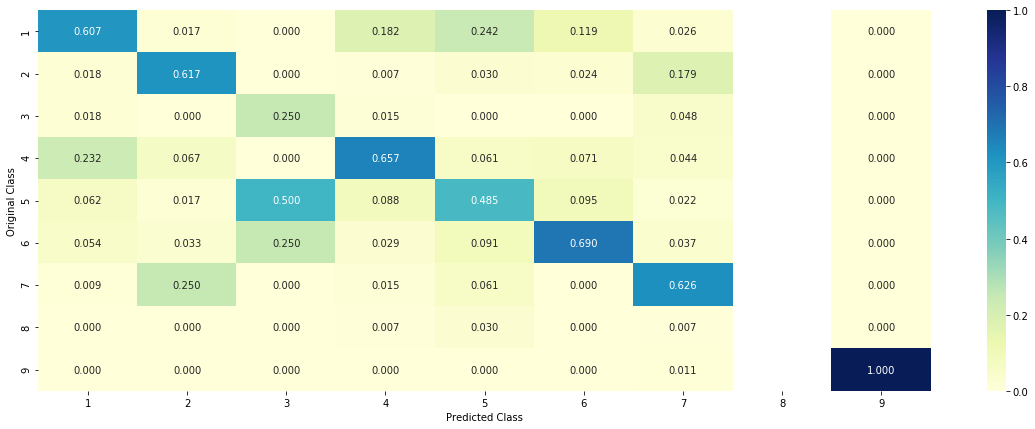

-------------------- Recall matrix (Row sum=1) --------------------


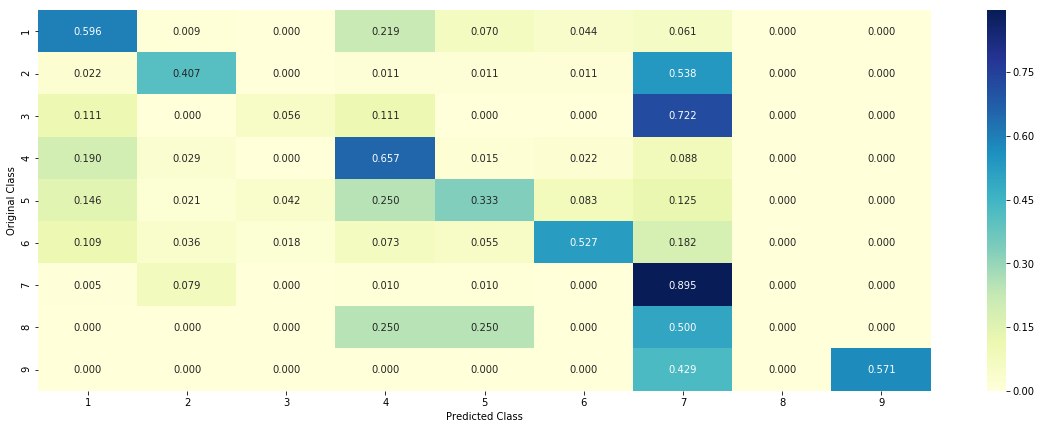

In [108]:
classifiers = [lr_model_tfidf, lsvm_model_tfidf, rf_model_tfidf]

alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_loss = 999
best_alpha = -1
best_model = None
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=classifiers, meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_tfidf, train_y)
    log_error = log_loss(cv_y, sclf.predict_proba(cv_x_tfidf))
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_error))
    if best_loss > log_error:
        best_loss = log_error
        best_alpha = i
        best_model = sclf

log_error = log_loss(train_y, best_model.predict_proba(train_x_tfidf))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, best_model.predict_proba(cv_x_tfidf))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, best_model.predict_proba(test_x_tfidf))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((best_model.predict(test_x_tfidf)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=best_model.predict(test_x_tfidf))

stacked_models_tfidf = best_model

**This stacked model also have bad results and individual models are better.**

**From previous examples we can clearly see that we can neglect Naive bayes and KNN as they are not doing better than any other models. And our first priority model to check is Logisitc Regression with balancing and next one may be random forest if dimensionality is reduced.**

### Taking only top 1000 features from Tf-Idf vectorizer

In [0]:
print(text_tfidf_vectorizer.idf_.shape)
print(len(train_text_features))
idf_dict = dict(zip(train_text_features, text_tfidf_vectorizer.idf_))

(54091,)
54091


In [0]:
idf_dict = sorted(idf_dict.items(), key=lambda x: x[1])
idf_dict = dict(idf_dict[:1000])
print(len(idf_dict))

1000


In [0]:
text_vectorizer = TfidfVectorizer(min_df=3, vocabulary=list(idf_dict.keys()))
train_text_feature_tfidf_1000 = text_vectorizer.fit_transform(train_df['TEXT'])

train_text_features = text_vectorizer.get_feature_names()

train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

text_fea_dict = dict(zip(list(train_text_features), train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 1000


In [0]:
train_text_features == list(idf_dict.keys())

True

In [0]:
train_text_feature_tfidf_1000 = normalize(train_text_feature_tfidf_1000, axis=0)

test_text_feature_tfidf_1000 = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_tfidf_1000 = normalize(test_text_feature_tfidf_1000, axis=0)

cv_text_feature_tfidf_1000 = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_tfidf_1000 = normalize(cv_text_feature_tfidf_1000, axis=0)

In [0]:
train_x_tfidf_1000 = hstack((train_gene_var_onehotCoding, train_text_feature_tfidf_1000)).tocsr()
test_x_tfidf_1000 = hstack((test_gene_var_onehotCoding, test_text_feature_tfidf_1000)).tocsr()
cv_x_tfidf_1000 = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidf_1000)).tocsr()

In [0]:
print("Tfidf features :")
print("(number of data points * number of features) in train data = ", train_x_tfidf_1000.shape)
print("(number of data points * number of features) in test data = ", test_x_tfidf_1000.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_tfidf_1000.shape)

Tfidf features :
(number of data points * number of features) in train data =  (2124, 3192)
(number of data points * number of features) in test data =  (665, 3192)
(number of data points * number of features) in cross validation data = (532, 3192)


**Let us use above models again to this new features and see the performance of the models. Now we can use Random forests as our dimensionality is less. (Note: if models perform bad I will not plot confusion matrix to reduce the length of our notebook)**

## Models with top 1000 features with TfIdf Encoded data

### Naive Bayes Model

For values of alpha =  1e-05 The log loss is: 1.1463289276244677
For values of alpha =  0.0001 The log loss is: 1.1462195473650876
For values of alpha =  0.001 The log loss is: 1.1449277953001882
For values of alpha =  0.1 The log loss is: 1.1840301877072736
For values of alpha =  1 The log loss is: 1.3308426811711134
For values of alpha =  10 The log loss is: 1.6165246847802603
For values of alpha =  100 The log loss is: 1.6131433548185017
For values of alpha =  1000 The log loss is: 1.592254399124329


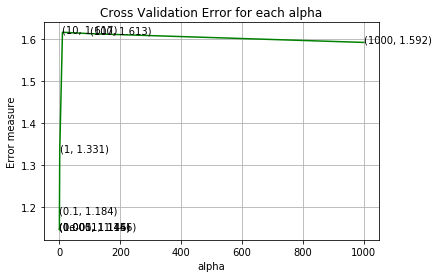

For values of best alpha =  0.001 The train log loss is: 0.5038723958374608
For values of best alpha =  0.001 The cross validation log loss is: 1.1449277953001882
For values of best alpha =  0.001 The test log loss is: 1.1980962960944195


In [0]:
nb_model_tfidf_1000 = generic_model_run(MultinomialNB, {}, {'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]},\
                  train_x_tfidf_1000, y_train,\
                  cv_x_tfidf_1000, y_cv,\
                  test_x_tfidf_1000, y_test)

In [0]:
generic_best_model_result(nb_model_tfidf_1000, test_x_tfidf_1000, y_test, False)

Log Loss : 1.1980962960944195
Number of missclassified point : 0.38646616541353385


### K Nearest Neighbour Classifier

For values of n_neighbors =  5 The log loss is: 1.031813353053317
For values of n_neighbors =  11 The log loss is: 1.0871597225989493
For values of n_neighbors =  15 The log loss is: 1.1173113780222186
For values of n_neighbors =  21 The log loss is: 1.143270501741529
For values of n_neighbors =  31 The log loss is: 1.1820413809234134
For values of n_neighbors =  41 The log loss is: 1.2153626870711565
For values of n_neighbors =  51 The log loss is: 1.2465152318352457
For values of n_neighbors =  99 The log loss is: 1.292039951560637


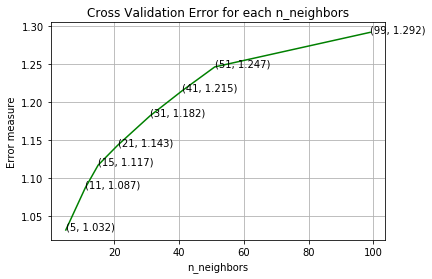

For values of best n_neighbors =  5 The train log loss is: 0.8969453323912671
For values of best n_neighbors =  5 The cross validation log loss is: 1.031813353053317
For values of best n_neighbors =  5 The test log loss is: 1.0881868416178164


In [0]:
knn_model_tfidf_1000 = generic_model_run(KNeighborsClassifier, {},\
                  {'n_neighbors': [5, 11, 15, 21, 31, 41, 51, 99]},\
                  train_x_tfidf_1000, y_train,\
                  cv_x_tfidf_1000, y_cv,\
                  test_x_tfidf_1000, y_test)

Log Loss : 1.0881868416178164
Number of missclassified point : 0.3699248120300752
-------------------- Confusion matrix --------------------


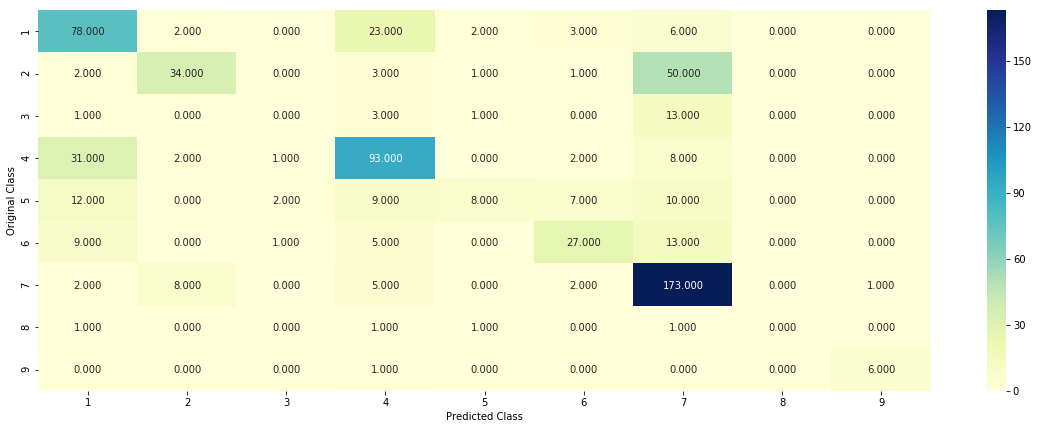

-------------------- Precision matrix (Columm Sum=1) --------------------


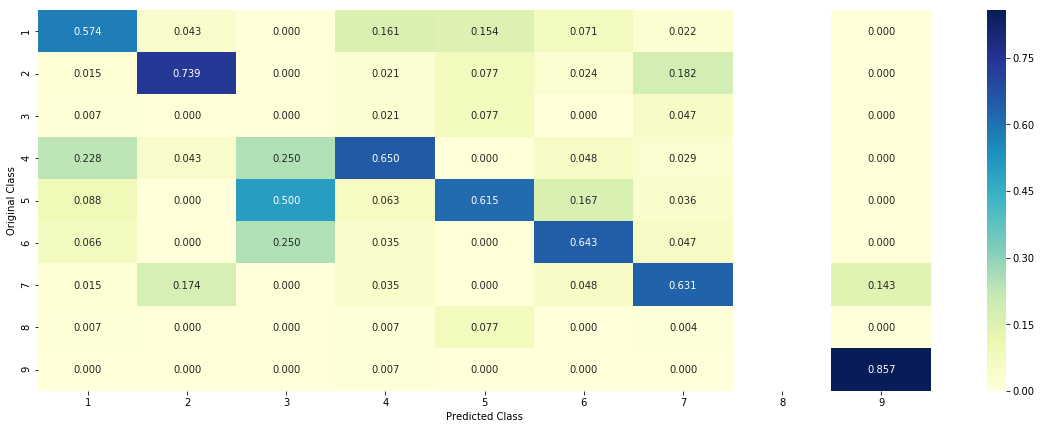

-------------------- Recall matrix (Row sum=1) --------------------


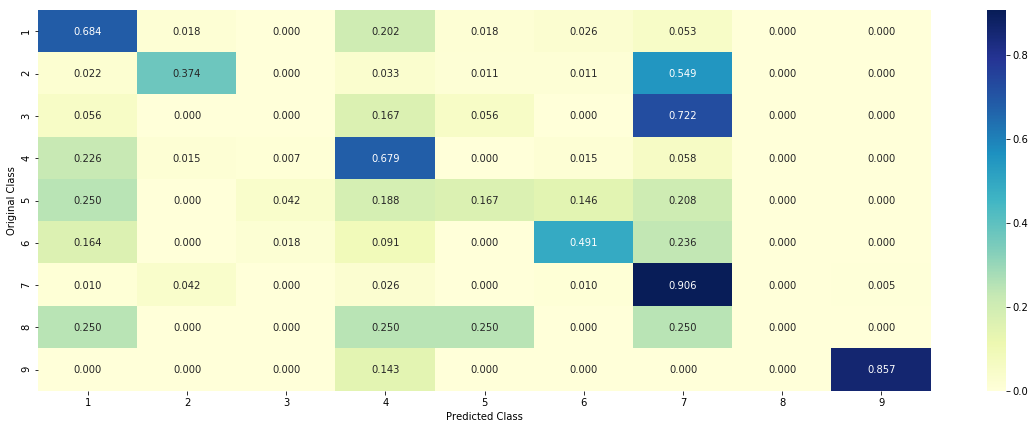

In [0]:
generic_best_model_result(knn_model_tfidf_1000, test_x_tfidf_1000, y_test)

**This KNN model did far better than previous KNN models this may indicate improvement in random forest as well.**

### Logistic Regression with class balancing

For values of alpha =  1e-06 The log loss is: 1.0485281075110593
For values of alpha =  1e-05 The log loss is: 1.0029098332399187
For values of alpha =  0.0001 The log loss is: 0.951672019896012
For values of alpha =  0.001 The log loss is: 0.9722982780128469
For values of alpha =  0.01 The log loss is: 1.1534425421960246
For values of alpha =  0.1 The log loss is: 1.4764718119679126
For values of alpha =  1 The log loss is: 1.6745590188710768
For values of alpha =  10 The log loss is: 1.7081351461185004
For values of alpha =  100 The log loss is: 1.7123820755841803


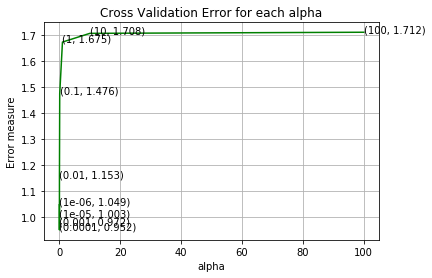

For values of best alpha =  0.0001 The train log loss is: 0.4435229440630971
For values of best alpha =  0.0001 The cross validation log loss is: 0.9583183317865825
For values of best alpha =  0.0001 The test log loss is: 1.031180415156161


In [0]:
params = {'class_weight': 'balanced', 'penalty': 'l2', 'loss': 'log'}
lr_model_tfidf_1000 = generic_model_run(SGDClassifier, params,\
                  {'alpha': [10 ** x for x in range(-6, 3)]},\
                  train_x_tfidf_1000, y_train,\
                  cv_x_tfidf_1000, y_cv,\
                  test_x_tfidf_1000, y_test)

Log Loss : 1.031180415156161
Number of missclassified point : 0.3383458646616541
-------------------- Confusion matrix --------------------


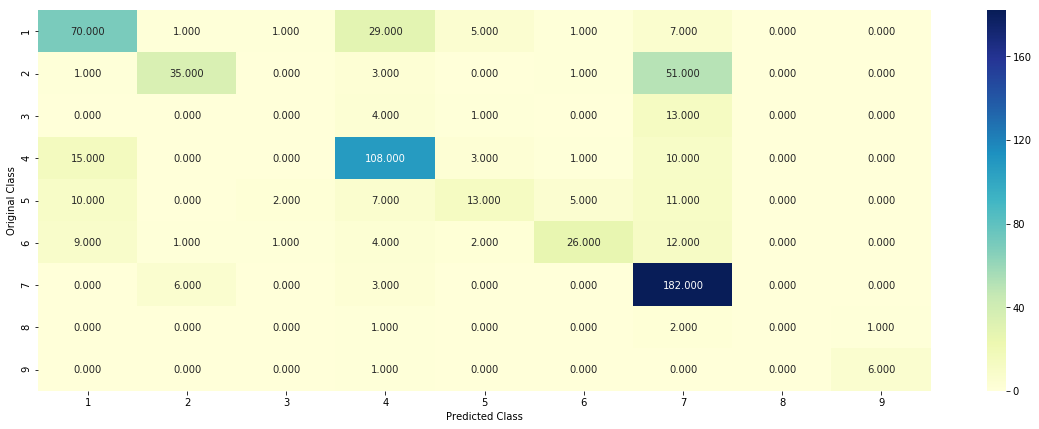

-------------------- Precision matrix (Columm Sum=1) --------------------


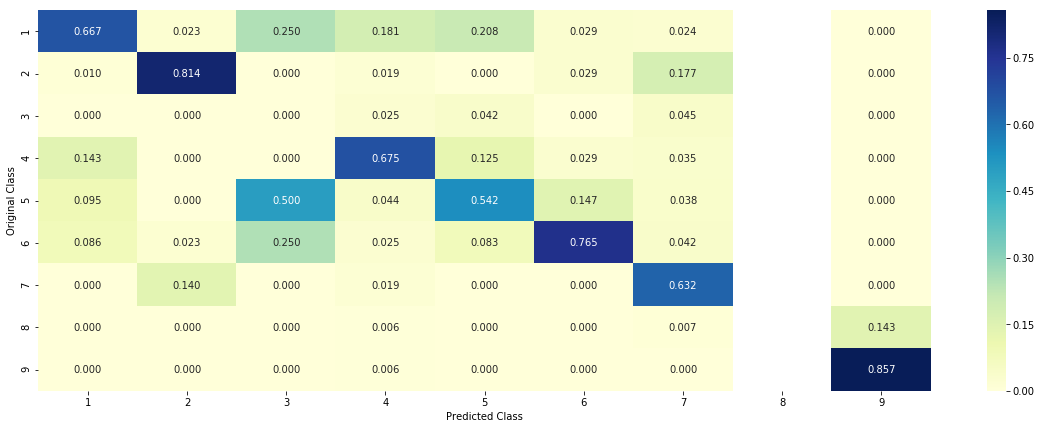

-------------------- Recall matrix (Row sum=1) --------------------


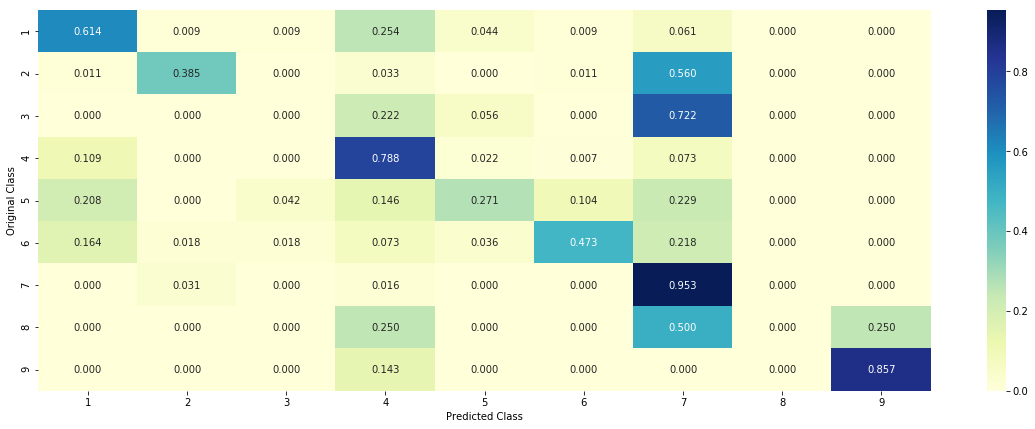

In [0]:
generic_best_model_result(lr_model_tfidf_1000, test_x_tfidf_1000, y_test)

**Logistic regression also gave better results than previous Logistic regression models. This has by far best log-loss and accuracy as log-loss = 1.03 and miss-classification rate = 33.83%**

### Logistic Regression without class balancing

For values of alpha =  1e-06 The log loss is: 1.0727265147394605
For values of alpha =  1e-05 The log loss is: 1.0673500439581178
For values of alpha =  0.0001 The log loss is: 1.0290868719368116
For values of alpha =  0.001 The log loss is: 1.1352988285486891
For values of alpha =  0.01 The log loss is: 1.2805708880275946
For values of alpha =  0.1 The log loss is: 1.562696397976556
For values of alpha =  1 The log loss is: 1.8008781992549479
For values of alpha =  10 The log loss is: 1.8354748456173111
For values of alpha =  100 The log loss is: 1.8396793868607653


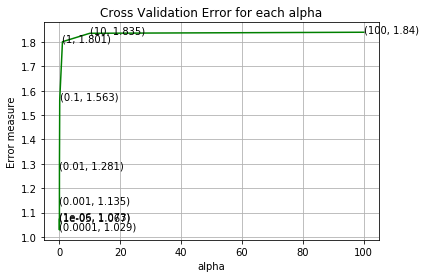

For values of best alpha =  0.0001 The train log loss is: 0.4360931470184161
For values of best alpha =  0.0001 The cross validation log loss is: 1.0384802858154396
For values of best alpha =  0.0001 The test log loss is: 1.0729932894737562


In [0]:
params = {'penalty': 'l2', 'loss': 'log'}
lr_ub_model_tfidf_1000 = generic_model_run(SGDClassifier, params,\
                  {'alpha': [10 ** x for x in range(-6, 3)]},\
                  train_x_tfidf_1000, y_train,\
                  cv_x_tfidf_1000, y_cv,\
                  test_x_tfidf_1000, y_test)

In [109]:
generic_best_model_result(lr_ub_model_tfidf_1000, test_x_tfidf_1000, y_test, False)

Log Loss : 1.0729932894737562
Number of missclassified point : 0.3368421052631579


**This model has good log-loss and best accuracy with miss-classification rate = 33.68%**

### Linear Support Vector Machines with balancing

For values of alpha =  1e-05 The log loss is: 1.0336450704275162
For values of alpha =  0.0001 The log loss is: 1.0142586993081157
For values of alpha =  0.001 The log loss is: 1.0096783209397076
For values of alpha =  0.01 The log loss is: 1.3732208249906206
For values of alpha =  0.1 The log loss is: 1.617880627746922
For values of alpha =  1 The log loss is: 1.7135144757528067
For values of alpha =  10 The log loss is: 1.713515102612863
For values of alpha =  100 The log loss is: 1.7135152138192626


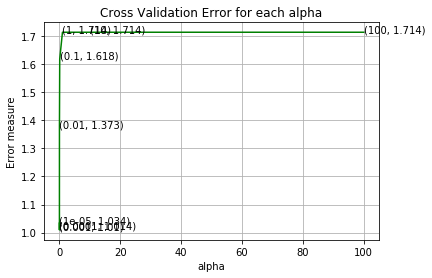

For values of best alpha =  0.001 The train log loss is: 0.5398141424351571
For values of best alpha =  0.001 The cross validation log loss is: 1.0126808671756828
For values of best alpha =  0.001 The test log loss is: 1.0927408246580015


In [0]:
params = {'class_weight': 'balanced', 'penalty': 'l2', 'loss': 'hinge'}
lsvm_model_tfidf_1000 = generic_model_run(SGDClassifier, params,\
                  {'alpha': [10 ** x for x in range(-5, 3)]},\
                  train_x_tfidf_1000, y_train,\
                  cv_x_tfidf_1000, y_cv,\
                  test_x_tfidf_1000, y_test)

In [110]:
generic_best_model_result(lsvm_model_tfidf_1000, test_x_tfidf_1000, y_test, False)

Log Loss : 1.0927408246580015
Number of missclassified point : 0.3548872180451128


### Linear Support Vector Machines without class balancing

For values of alpha =  1e-05 The log loss is: 1.0648918534831533
For values of alpha =  0.0001 The log loss is: 1.0170657017436062
For values of alpha =  0.001 The log loss is: 1.0333631175458002
For values of alpha =  0.01 The log loss is: 1.4144346808366541
For values of alpha =  0.1 The log loss is: 1.725440199719906
For values of alpha =  1 The log loss is: 1.840792645277739
For values of alpha =  10 The log loss is: 1.840792612977028
For values of alpha =  100 The log loss is: 1.8407926894325357


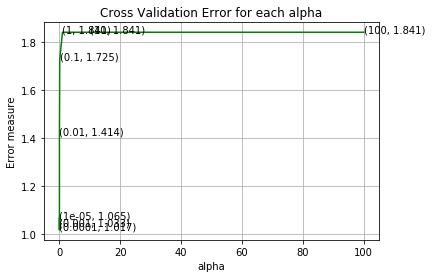

For values of best alpha =  0.0001 The train log loss is: 0.3955871890038449
For values of best alpha =  0.0001 The cross validation log loss is: 1.019115367620495
For values of best alpha =  0.0001 The test log loss is: 1.0794613500651058


In [0]:
params = {'penalty': 'l2', 'loss': 'hinge'}
lsvm_ub_model_tfidf_1000 = generic_model_run(SGDClassifier, params,\
                  {'alpha': [10 ** x for x in range(-5, 3)]},\
                  train_x_tfidf_1000, y_train,\
                  cv_x_tfidf_1000, y_cv,\
                  test_x_tfidf_1000, y_test)

Log Loss : 1.0794613500651058
Number of missclassified point : 0.3383458646616541
-------------------- Confusion matrix --------------------


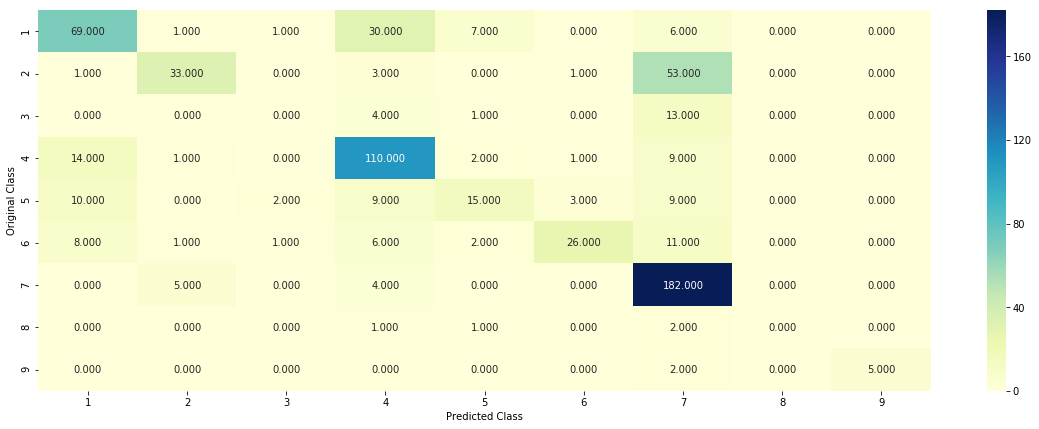

-------------------- Precision matrix (Columm Sum=1) --------------------


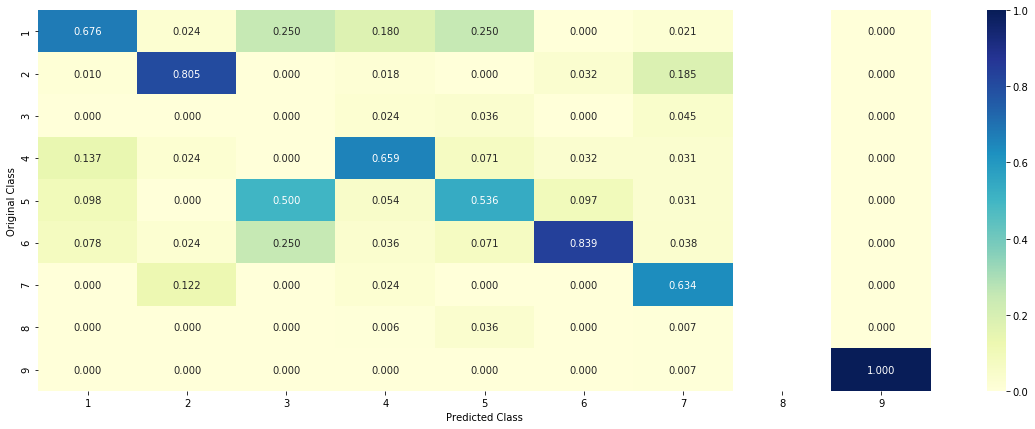

-------------------- Recall matrix (Row sum=1) --------------------


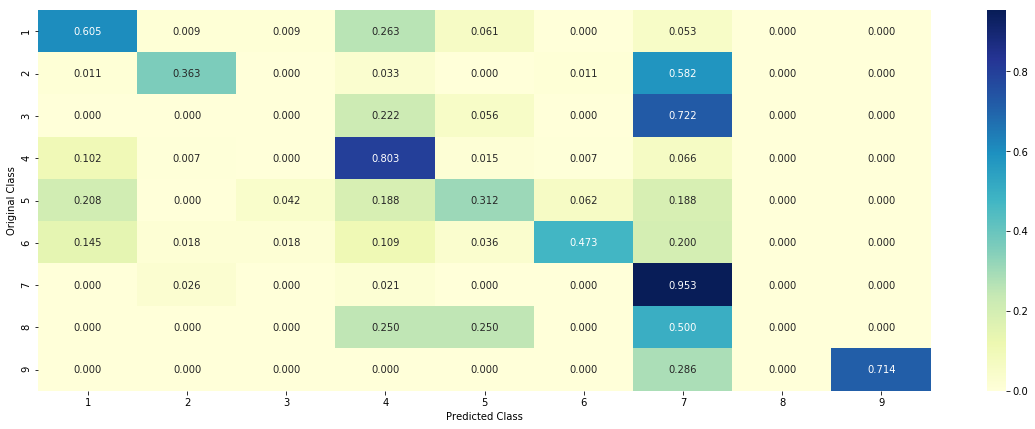

In [111]:
generic_best_model_result(lsvm_ub_model_tfidf_1000, test_x_tfidf_1000, y_test)

**Both Linear SVM models did better than previous SVM models. and accuracy of SVM model without balancing is pretty good.**

### Random Forest Classifier

For values of n_estimators =  10 The log loss is: 1.4879390164148587
For values of n_estimators =  50 The log loss is: 1.3645976647478149
For values of n_estimators =  100 The log loss is: 1.3360227610101938
For values of n_estimators =  200 The log loss is: 1.3249974683018848
For values of n_estimators =  500 The log loss is: 1.3209116561599998
For values of n_estimators =  1000 The log loss is: 1.320422140897469


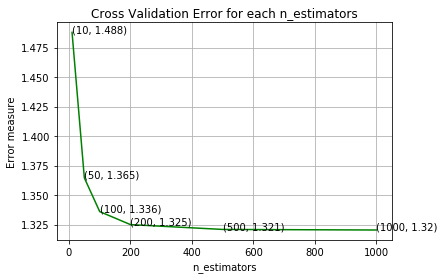

For values of best n_estimators =  1000 The train log loss is: 0.4550250676658763
For values of best n_estimators =  1000 The cross validation log loss is: 1.316796389433742
For values of best n_estimators =  1000 The test log loss is: 1.2984142543090114


In [0]:
params = {'criterion': 'gini', 'max_depth': 20, 'n_jobs': -1}
rf_model_tfidf_1000 = generic_model_run(RandomForestClassifier, params,\
                  {'n_estimators': [10,50,100,200,500,1000]},\
                  train_x_tfidf_1000, y_train,\
                  cv_x_tfidf_1000, y_cv,\
                  test_x_tfidf_1000, y_test)

In [0]:
generic_best_model_result(rf_model_tfidf_1000, test_x_tfidf_1000, y_test, False)

Log Loss : 1.2984142543090114
Number of missclassified point : 0.37593984962406013


**Surprisingly Random forest models didnt give better results than previous models where number of dimensions is more. log-loss increased a lot and accuracy is also not good.**

### Count vectorization with bi-grams

In [0]:
text_vectorizer = CountVectorizer(min_df=3, ngram_range=(1, 2), max_features=500000)
train_text_feature_ohe_bi = text_vectorizer.fit_transform(train_df['TEXT'])

train_text_features = text_vectorizer.get_feature_names()
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 500000


**Limiting number of features to 500000 and it can be reduced further as less number of dimensions gives better results for all models including Logistic Regression.**

In [0]:
train_text_feature_ohe_bi = normalize(train_text_feature_ohe_bi, axis=0)

test_text_feature_ohe_bi = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_ohe_bi = normalize(test_text_feature_ohe_bi, axis=0)

cv_text_feature_ohe_bi = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_ohe_bi = normalize(cv_text_feature_ohe_bi, axis=0)

In [0]:
train_x_ohe_bi = hstack((train_gene_var_onehotCoding, train_text_feature_ohe_bi)).tocsr()
test_x_ohe_bi = hstack((test_gene_var_onehotCoding, test_text_feature_ohe_bi)).tocsr()
cv_x_ohe_bi = hstack((cv_gene_var_onehotCoding, cv_text_feature_ohe_bi)).tocsr()

In [0]:
print("Tfidf features :")
print("(number of data points * number of features) in train data = ", train_x_ohe_bi.shape)
print("(number of data points * number of features) in test data = ", test_x_ohe_bi.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_ohe_bi.shape)

Tfidf features :
(number of data points * number of features) in train data =  (2124, 502192)
(number of data points * number of features) in test data =  (665, 502192)
(number of data points * number of features) in cross validation data = (532, 502192)


### Logistic Regression on bigram vectorized features

For values of alpha =  1e-06 The log loss is: 1.4600879785176455
For values of alpha =  1e-05 The log loss is: 1.4631473008907365
For values of alpha =  0.0001 The log loss is: 1.3587912053717188
For values of alpha =  0.001 The log loss is: 1.1675723983780064
For values of alpha =  0.01 The log loss is: 1.1611281529944975
For values of alpha =  0.1 The log loss is: 1.2011866819482675
For values of alpha =  1 The log loss is: 1.2988718002365909
For values of alpha =  10 The log loss is: 1.381554499730234
For values of alpha =  100 The log loss is: 1.396096659547829


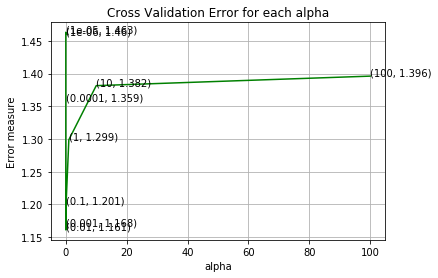

For values of best alpha =  0.01 The train log loss is: 0.7086723695102845
For values of best alpha =  0.01 The cross validation log loss is: 1.1583240175395584
For values of best alpha =  0.01 The test log loss is: 1.1516841420186197


In [0]:
params = {'class_weight': 'balanced', 'penalty': 'l2', 'loss': 'log'}
lr_model_ohe_bi = generic_model_run(SGDClassifier, params,\
                  {'alpha': [10 ** x for x in range(-6, 3)]},\
                  train_x_ohe_bi, y_train,\
                  cv_x_ohe_bi, y_cv,\
                  test_x_ohe_bi, y_test)

**Our logistic regression didnt do good when compared to previous models. this log-loss is worse than that of Logistic regression with only text features as input.**

### Tfidf vectorization with bi-grams

In [0]:
text_vectorizer = TfidfVectorizer(min_df=3, ngram_range=(1, 2), max_features=500000)
train_text_feature_tfidf_bi = text_vectorizer.fit_transform(train_df['TEXT'])

train_text_features = text_vectorizer.get_feature_names()
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 500000


In [0]:
train_text_feature_tfidf_bi = normalize(train_text_feature_tfidf_bi, axis=0)

test_text_feature_tfidf_bi = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_tfidf_bi = normalize(test_text_feature_tfidf_bi, axis=0)

cv_text_feature_tfidf_bi = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_tfidf_bi = normalize(cv_text_feature_tfidf_bi, axis=0)

In [0]:
train_x_tfidf_bi = hstack((train_gene_var_onehotCoding, train_text_feature_tfidf_bi)).tocsr()
test_x_tfidf_bi = hstack((test_gene_var_onehotCoding, test_text_feature_tfidf_bi)).tocsr()
cv_x_tfidf_bi = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidf_bi)).tocsr()

In [0]:
print("Tfidf features :")
print("(number of data points * number of features) in train data = ", train_x_tfidf_bi.shape)
print("(number of data points * number of features) in test data = ", test_x_tfidf_bi.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_tfidf_bi.shape)

Tfidf features :
(number of data points * number of features) in train data =  (2124, 502192)
(number of data points * number of features) in test data =  (665, 502192)
(number of data points * number of features) in cross validation data = (532, 502192)


### Logistic Regression on bigram vectorized features

For values of alpha =  1e-06 The log loss is: 1.493552498021559
For values of alpha =  1e-05 The log loss is: 1.4830941549345622
For values of alpha =  0.0001 The log loss is: 1.400555299470195
For values of alpha =  0.001 The log loss is: 1.1124498183666147
For values of alpha =  0.01 The log loss is: 1.115768718444329
For values of alpha =  0.1 The log loss is: 1.1448744717388226
For values of alpha =  1 The log loss is: 1.200487534483955
For values of alpha =  10 The log loss is: 1.2396773785367754
For values of alpha =  100 The log loss is: 1.246833280841604


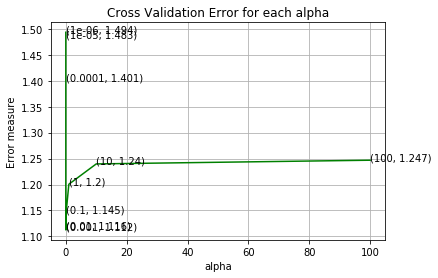

For values of best alpha =  0.001 The train log loss is: 0.6223366724447282
For values of best alpha =  0.001 The cross validation log loss is: 1.1151433290518564
For values of best alpha =  0.001 The test log loss is: 1.1030324309858885


In [0]:
params = {'class_weight': 'balanced', 'penalty': 'l2', 'loss': 'log'}
lr_model_tfidf_bi = generic_model_run(SGDClassifier, params,\
                  {'alpha': [10 ** x for x in range(-6, 3)]},\
                  train_x_tfidf_bi, y_train,\
                  cv_x_tfidf_bi, y_cv,\
                  test_x_tfidf_bi, y_test)

**Taking Tfidf features with bi-grams improved the log-loss but didnt give best results.**

**Let us try logistic regression with top 2500 unigram and bigram features and see whether it will improve the models performance.**

In [116]:
print(text_vectorizer.idf_.shape)
print(len(train_text_features))
idf_dict = dict(zip(train_text_features, text_vectorizer.idf_))

(500000,)
500000


In [117]:
idf_dict = sorted(idf_dict.items(), key=lambda x: x[1])
idf_dict = dict(idf_dict[:2500])
print(len(idf_dict))

2500


In [123]:
text_vectorizer = TfidfVectorizer(min_df=3, vocabulary=list(idf_dict.keys()))
train_text_feature_tfidf_bi_2500 = text_vectorizer.fit_transform(train_df['TEXT'])

train_text_features = text_vectorizer.get_feature_names()
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 2500


In [124]:
train_text_features == list(idf_dict.keys())

True

In [0]:
train_text_feature_tfidf_bi_2500 = normalize(train_text_feature_tfidf_bi_2500, axis=0)

test_text_feature_tfidf_bi_2500 = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_tfidf_bi_2500 = normalize(test_text_feature_tfidf_bi_2500, axis=0)

cv_text_feature_tfidf_bi_2500 = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_tfidf_bi_2500 = normalize(cv_text_feature_tfidf_bi_2500, axis=0)

In [0]:
train_x_tfidf_bi_2500 = hstack((train_gene_var_onehotCoding, train_text_feature_tfidf_bi_2500)).tocsr()
test_x_tfidf_bi_2500 = hstack((test_gene_var_onehotCoding, test_text_feature_tfidf_bi_2500)).tocsr()
cv_x_tfidf_bi_2500 = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidf_bi_2500)).tocsr()

In [127]:
print("Tfidf features :")
print("(number of data points * number of features) in train data = ", train_x_tfidf_bi_2500.shape)
print("(number of data points * number of features) in test data = ", test_x_tfidf_bi_2500.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_tfidf_bi_2500.shape)

Tfidf features :
(number of data points * number of features) in train data =  (2124, 4692)
(number of data points * number of features) in test data =  (665, 4692)
(number of data points * number of features) in cross validation data = (532, 4692)


For values of alpha =  1e-06 The log loss is: 1.0053705082737783
For values of alpha =  1e-05 The log loss is: 0.9469338632336871
For values of alpha =  0.0001 The log loss is: 0.8955121047998112
For values of alpha =  0.001 The log loss is: 0.9266316709371164
For values of alpha =  0.01 The log loss is: 1.0983151171801773
For values of alpha =  0.1 The log loss is: 1.661915081931572
For values of alpha =  1 The log loss is: 1.8856526122815869
For values of alpha =  10 The log loss is: 1.9070592436023635
For values of alpha =  100 The log loss is: 1.9091815385204718


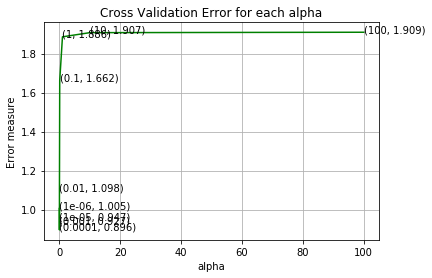

For values of best alpha =  0.0001 The train log loss is: 0.4269025772667059
For values of best alpha =  0.0001 The cross validation log loss is: 0.8986919505330523
For values of best alpha =  0.0001 The test log loss is: 0.9709944881295604


In [128]:
params = {'class_weight': 'balanced', 'penalty': 'l2', 'loss': 'log'}
lr_model_tfidf_bi_2500 = generic_model_run(SGDClassifier, params,\
                  {'alpha': [10 ** x for x in range(-6, 3)]},\
                  train_x_tfidf_bi_2500, y_train,\
                  cv_x_tfidf_bi_2500, y_cv,\
                  test_x_tfidf_bi_2500, y_test)

Log Loss : 0.9709944881295604
Number of missclassified point : 0.3218045112781955
-------------------- Confusion matrix --------------------


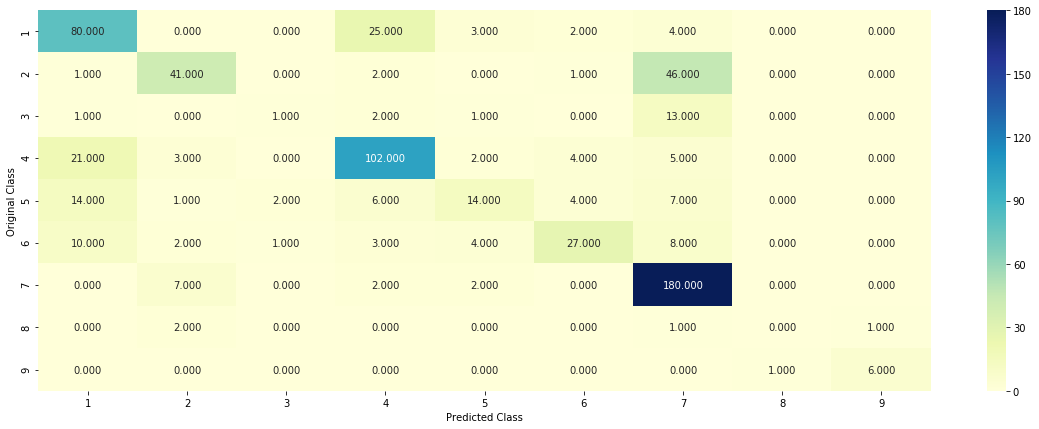

-------------------- Precision matrix (Columm Sum=1) --------------------


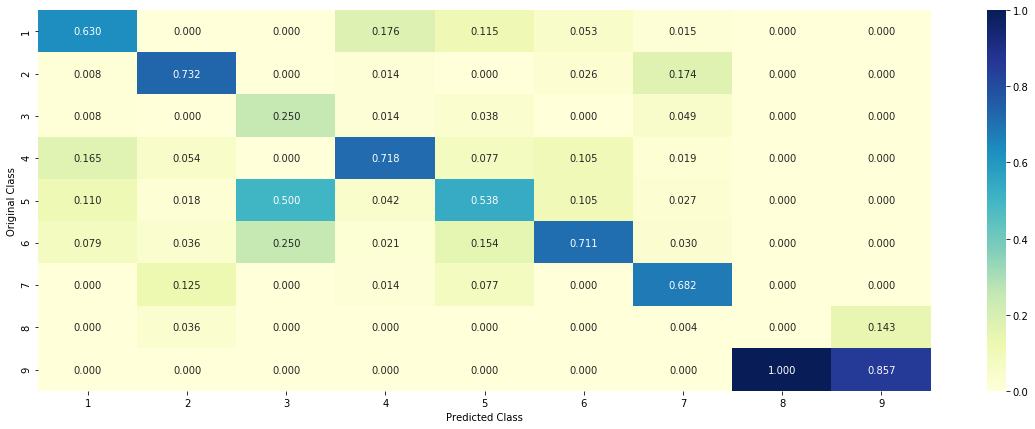

-------------------- Recall matrix (Row sum=1) --------------------


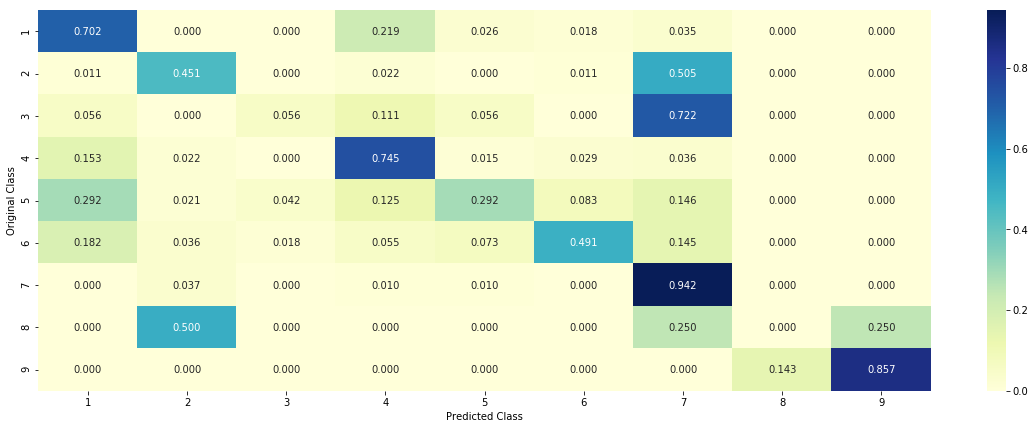

In [129]:
generic_best_model_result(lr_model_tfidf_bi_2500, test_x_tfidf_bi_2500, y_test)

**The above model gave best results among all the models and our cv log-loss and test log-loss are below 1 (0.899 and 0.971 respectively). And our accuarcy also improved from previous models as miss-classified points are 32.18%. </br> </br>
Reducing the number of features by taking top features affected our model's performance a lot. So want to see the affect of number of top features on the model's accuracy. Here 2500 is choosen randomly so trying different values to see how it might affect our model.**

For top 1000 features:


For values of alpha =  1e-06 The log loss is: 1.0697171364755098
For values of alpha =  1e-05 The log loss is: 0.9899341058032364
For values of alpha =  0.0001 The log loss is: 0.9517867376575107
For values of alpha =  0.001 The log loss is: 0.9771465575372693
For values of alpha =  0.01 The log loss is: 1.1556153189436915
For values of alpha =  0.1 The log loss is: 1.4730067026477884
For values of alpha =  1 The log loss is: 1.6704019892190514
For values of alpha =  10 The log loss is: 1.7049346577487847
For values of alpha =  100 The log loss is: 1.7095569996871407


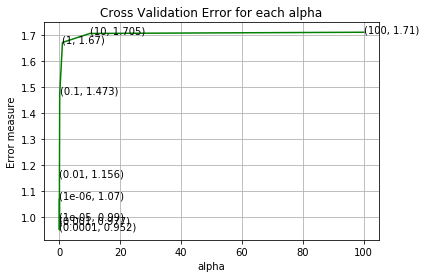

For values of best alpha =  0.0001 The train log loss is: 0.4453584351435555
For values of best alpha =  0.0001 The cross validation log loss is: 0.9537259970524389
For values of best alpha =  0.0001 The test log loss is: 1.0347532789450766




For top 3000 features:


For values of alpha =  1e-06 The log loss is: 1.018523829857023
For values of alpha =  1e-05 The log loss is: 0.9311811345316825
For values of alpha =  0.0001 The log loss is: 0.8905189314974788
For values of alpha =  0.001 The log loss is: 0.917821117344816
For values of alpha =  0.01 The log loss is: 1.0859023406676873
For values of alpha =  0.1 The log loss is: 1.6881505553213723
For values of alpha =  1 The log loss is: 1.9105424197318783
For values of alpha =  10 The log loss is: 1.9300746394273784
For values of alpha =  100 The log loss is: 1.9316533464830656


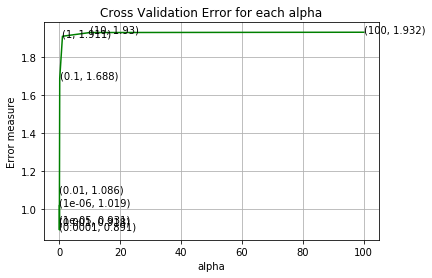

For values of best alpha =  0.0001 The train log loss is: 0.422466453334396
For values of best alpha =  0.0001 The cross validation log loss is: 0.8988242835225527
For values of best alpha =  0.0001 The test log loss is: 0.9764964724279551




For top 5000 features:


For values of alpha =  1e-06 The log loss is: 0.9830064677563897
For values of alpha =  1e-05 The log loss is: 0.9579711951500457
For values of alpha =  0.0001 The log loss is: 0.8998960645384664
For values of alpha =  0.001 The log loss is: 0.9175350067724047
For values of alpha =  0.01 The log loss is: 1.0582760833138487
For values of alpha =  0.1 The log loss is: 1.7765815729375884
For values of alpha =  1 The log loss is: 2.021906718184498
For values of alpha =  10 The log loss is: 2.039021379527279
For values of alpha =  100 The log loss is: 2.0408633125954254


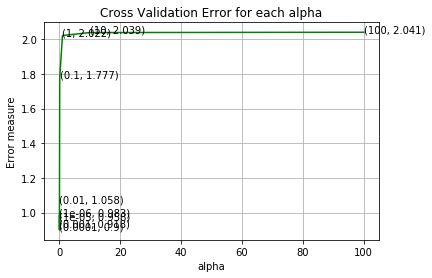

For values of best alpha =  0.0001 The train log loss is: 0.41764839371256834
For values of best alpha =  0.0001 The cross validation log loss is: 0.9050837613882672
For values of best alpha =  0.0001 The test log loss is: 0.9952937980425581




For top 8000 features:


For values of alpha =  1e-06 The log loss is: 1.0688966110671163
For values of alpha =  1e-05 The log loss is: 1.001877274606549
For values of alpha =  0.0001 The log loss is: 0.9392170385526827
For values of alpha =  0.001 The log loss is: 0.9354361092849044
For values of alpha =  0.01 The log loss is: 1.0480425507018205
For values of alpha =  0.1 The log loss is: 1.7604156846133907
For values of alpha =  1 The log loss is: 1.982599588746501
For values of alpha =  10 The log loss is: 1.9977639206219988
For values of alpha =  100 The log loss is: 1.9991039029543607


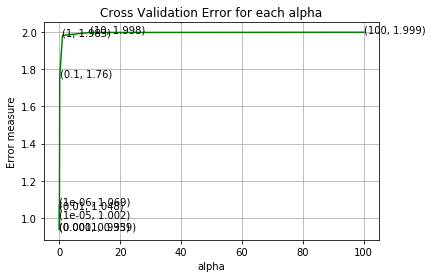

For values of best alpha =  0.001 The train log loss is: 0.6096110222997297
For values of best alpha =  0.001 The cross validation log loss is: 0.9387348456320849
For values of best alpha =  0.001 The test log loss is: 1.0270246130845126




For top 10000 features:


For values of alpha =  1e-06 The log loss is: 1.0460407657244222
For values of alpha =  1e-05 The log loss is: 1.0143422831836242
For values of alpha =  0.0001 The log loss is: 0.9458167602117427
For values of alpha =  0.001 The log loss is: 0.942324230576203
For values of alpha =  0.01 The log loss is: 1.0435600435471644
For values of alpha =  0.1 The log loss is: 1.7684181555721357
For values of alpha =  1 The log loss is: 2.0019866118053233
For values of alpha =  10 The log loss is: 2.0168108833087715
For values of alpha =  100 The log loss is: 2.0184095925580285


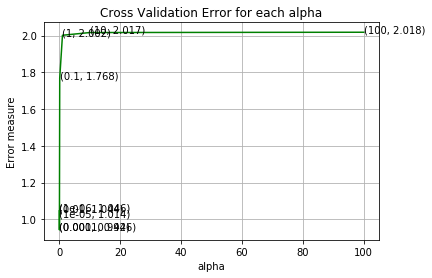

For values of best alpha =  0.001 The train log loss is: 0.6007247409130457
For values of best alpha =  0.001 The cross validation log loss is: 0.9424801959445568
For values of best alpha =  0.001 The test log loss is: 1.0237430636523217






In [136]:
text_vectorizer = TfidfVectorizer(min_df=3, ngram_range=(1, 2))
text_vectorizer.fit(train_df['TEXT'])

train_text_features = text_vectorizer.get_feature_names()
idf_dict = dict(zip(train_text_features, text_vectorizer.idf_))
idf_dict = sorted(idf_dict.items(), key=lambda x: x[1])

top_feat_nums = [1000, 3000, 5000, 8000, 10000]
all_best_models = {}

for num in top_feat_nums:
  idf_top_dict = dict(idf_dict[:num])
  temp_vect = TfidfVectorizer(min_df=3, vocabulary=list(idf_top_dict.keys()))

  train_text_feat = temp_vect.fit_transform(train_df['TEXT'])
  train_text_feat = normalize(train_text_feat, axis=0)

  test_text_feat = temp_vect.transform(test_df['TEXT'])
  test_text_feat = normalize(test_text_feat, axis=0)

  cv_text_feat = temp_vect.transform(cv_df['TEXT'])
  cv_text_feat = normalize(cv_text_feat, axis=0)

  train_temp_x = hstack((train_gene_var_onehotCoding, train_text_feat)).tocsr()
  test_temp_x = hstack((test_gene_var_onehotCoding, test_text_feat)).tocsr()
  cv_temp_x = hstack((cv_gene_var_onehotCoding, cv_text_feat)).tocsr()

  params = {'class_weight': 'balanced', 'penalty': 'l2', 'loss': 'log'}
  print(f"For top {num} features:")
  print('\n')
  temp_best_model = generic_model_run(SGDClassifier, params,\
                  {'alpha': [10 ** x for x in range(-6, 3)]},\
                  train_temp_x, y_train, cv_temp_x, y_cv, test_temp_x, y_test)
  all_best_models[num] = temp_best_model
  print('\n')
  print("="*150)
  print('\n')


**Model with top 3000 features did good but not as good as 2500 featured model. Previous model with top 2500 features have better results than all other models we tried in the loop. So considering this as best model.**

## Conclusion:

In [140]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Model', 'Features transform', 'Hyper parameter', 'Train log loss', 'Test log loss', 'miss-classified (%)']
table.add_row(['Random Classifier', '-', '-', 2.471, 2.513, '-'])
table.add_row(['Dummy Prior Classifier', '-', '-', 1.83, 1.831, '-'])
table.add_row(['Logistic Regression', 'Only Gene feature', 'alpha = 0.0001', 1.014, 1.189, '-'])
table.add_row(['Logistic Regression', 'Only Variation feature', 'alpha = 0.0001', 1.014, 1.189, '-'])
table.add_row(['Logistic Regression', 'Only Text feature', 'alpha = 0.001', 0.618, 1.12, '-'])
table.add_row(['Naive Bayes', 'OnehotCoding', 'alpha = 0.1', 0.88, 1.236, 37.594])
table.add_row(['KNN', 'OnehotCoding', 'n_neighbs = 5', 1.024, 1.273, 42.255])
table.add_row(['LR balanced', 'OnehotCoding', 'alpha = 0.001', 0.562, 1.087, 35.188])
table.add_row(['LR unbalanced', 'OnehotCoding', 'alpha = 0.001', 0.567, 1.106, 35.488])
table.add_row(['LSVM balanced', 'OnehotCoding', 'alpha = 0.001', 0.573, 1.124, 33.834])
table.add_row(['LSVM unbalanced', 'OnehotCoding', 'alpha = 0.01', 0.725, 1.155, 35.639])
table.add_row(['Random Forest', 'OnehotCoding', 'n_estim = 1000', 0.481, 1.171, 38.045])
table.add_row(['Stacked Model', 'OnehotCoding', 'alpha = 0.1', 0.424, 1.098, 34.135])
table.add_row(['Random Forest', 'Response Coding', 'n_estim = 200', 0.032, 1.808, 69.173])
table.add_row(['Naive Bayes', 'Tfidf', 'alpha = 0.1', 0.867, 1.254, 37.744])
table.add_row(['KNN', 'Tfidf', 'n_neighbs = 5', 1.006, 1.301, 43.458])
table.add_row(['LR balanced', 'Tfidf', 'alpha = 0.001', 0.525, 1.049, 36.24])
table.add_row(['LR unbalanced', 'Tfidf', 'alpha = 0.001', 0.524, 1.067, 36.09])
table.add_row(['LSVM balanced', 'Tfidf', 'alpha = 0.001', 0.561, 1.101, 35.789])
table.add_row(['LSVM unbalanced', 'Tfidf', 'alpha = 0.001', 0.538, 1.118, 35.94])
table.add_row(['Random Forest', 'Tfidf', 'n_estim = 1000', 0.472, 1.201, 40.301])
table.add_row(['Stacked Model', 'Tfidf', 'alpha = 0.1', 0.41, 1.116, 37.443])
table.add_row(['Naive Bayes', 'Tfidf top 1000', 'alpha = 0.001', 0.504, 1.198, 38.646])
table.add_row(['KNN', 'Tfidf top 1000', 'n_neighbs = 5', 0.897, 1.088, 37.992])
table.add_row(['LR balanced', 'Tfidf top 1000', 'alpha = 0.0001', 0.443, 1.031, 33.834])
table.add_row(['LR unbalanced', 'Tfidf top 1000', 'alpha = 0.0001', 0.436, 1.073, 33.684])
table.add_row(['LSVM balanced', 'Tfidf top 1000', 'alpha = 0.001', 0.54, 1.093, 35.488])
table.add_row(['LSVM unbalanced', 'Tfidf top 1000', 'alpha = 0.0001', 0.395, 1.079, 33.834])
table.add_row(['Random Forest', 'Tfidf top 1000', 'n_estim = 1000', 0.455, 1.298, 37.594])
table.add_row(['LR balanced', 'OnehotCoding bigram', 'alpha = 0.01', 0.708, 1.151, '-'])
table.add_row(['LR balanced', 'Tfidf bigram', 'alpha = 0.001', 0.622, 1.103, '-'])
table.add_row(['LR balanced', 'Tfidf bigram top 2500', 'alpha = 0.0001', 0.427, 0.971, 32.18])
table.add_row(['LR balanced', 'Tfidf bigram top 3000', 'alpha = 0.0001', 0.422, 0.976, '-'])

print(table)

+------------------------+------------------------+-----------------+----------------+---------------+---------------------+
|         Model          |   Features transform   | Hyper parameter | Train log loss | Test log loss | miss-classified (%) |
+------------------------+------------------------+-----------------+----------------+---------------+---------------------+
|   Random Classifier    |           -            |        -        |     2.471      |     2.513     |          -          |
| Dummy Prior Classifier |           -            |        -        |      1.83      |     1.831     |          -          |
|  Logistic Regression   |   Only Gene feature    |  alpha = 0.0001 |     1.014      |     1.189     |          -          |
|  Logistic Regression   | Only Variation feature |  alpha = 0.0001 |     1.014      |     1.189     |          -          |
|  Logistic Regression   |   Only Text feature    |  alpha = 0.001  |     0.618      |      1.12     |          -          |


**The above table consists all the models except last models in the loop. Here LR is Logistic Regression, LSVM is Linear SVM, and for some models miss-classified points are not calculated so for them it is empty.**

**Conclusion:**
- **Logistic Regression did very good when compared to all other models. and Balancing data is also better because model's performance increased by doing it.**
- **Stacked models didnt give better performance than Logistic Regression which might be due to Logistic Regression being very good and others being not good affected our overall performance of Stacked model.**
- **Reducing dimensions of the input data increased every models performance except Random Forest performance.**
- **Taking all unigram and bigram text features reduced our Logistic Regression performace. So our final model which did good is taking top 2500 features from unigram and bigram text features due to which best log-loss and accuracy are obtained.**
- **And when confusion matrices are observed, classes which have less data points (unbalanced data) like class 3, 5, 8 are suffering a lot even in our best model. Especially class 8 is not detected properly in almost all models except for SVM model with Tfidf vectorization (Other classes 3, 5 are detected in few models but class 8 is worse of all). As it is medical related problem we need to take care of that by introducing more complex models and good data such that these classes are not neglected and detected properly.**